<a href="https://colab.research.google.com/github/Phantom-Ren/PR_TH/blob/master/TPA_Sensor_Human_Target_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# 毕业设计完整后台代码流程

#### 纪泽西 17375338

#### Last Modified:4th,June,2021

</center>

<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/Phantom-Ren/PR_TH/blob/master/TPA_Sensor_Human_Target_Localization.ipynb"> 
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" /><br>Run in Google Colab</a></td>
</table>


### 调用环境及库函数

In [ ]:
import xml.parsers.expat
from xml.etree.cElementTree import Element, SubElement, parse
import cv2
import random
import numpy as np
import copy
import matplotlib.pyplot as plt
import PIL.Image as image
from skimage import measure
import warnings
warnings.filterwarnings("ignore", category=Warning)

%tensorflow_version 2.x
import tensorflow as tf
import sklearn
from sklearn.cluster import KMeans
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

%cd /content/drive/MyDrive/Colab Notebooks/毕业设计

/content/drive/MyDrive/Colab Notebooks/毕业设计


### 1.导入XML&获取有效帧

In [ ]:
def get_tpa_xml(frames,frame_num,com_num):
  data_by_row = frames[frame_num].getchildren()[0].getchildren()[com_num].getchildren()
  for i in range(0,24):
    temp=np.array(data_by_row[i+2].text.split(),dtype='float')
    if i==0:
      tpa_data=copy.deepcopy(temp)
    else:
      tpa_data=np.insert(tpa_data,32*i,temp,axis=0)
  tpa_data=tpa_data.reshape((24,32))
  return tpa_data  

def get_tpa_loc(info):
  loc = info[2].getchildren()[1].getchildren()
  X = np.array(loc[1].text.split(),dtype='float')
  Y = np.array(loc[2].text.split(),dtype='float')
  Angle = np.array(loc[3].text.split(),dtype='float')
  return X,Y,Angle

In [ ]:
xml1 = parse('./单人.xml')
root = xml1.getroot()
datas = root.find('Data')
info = root.find('Information')
frames = datas.getchildren()
f_aval=[]
for i in range(len(frames)):
  if len(frames[i].getchildren()[0].getchildren())!=0:
    f_aval.append(i)
print('%d in %d frames are available\n'%(len(f_aval),len(frames)))  

241 in 976 frames are available



In [ ]:
loc_x,loc_y,loc_angle = get_tpa_loc(info)
for i in range(loc_x.shape[0]):
  print('No.%d TPA Sensors at %.1f,%.1f,%d deg'%(i+1,loc_x[i],loc_y[i],loc_angle[i]))

No.1 TPA Sensors at 404.5,150.0,0 deg
No.2 TPA Sensors at 430.0,410.5,-90 deg
No.3 TPA Sensors at 210.0,410.5,90 deg
No.4 TPA Sensors at 320.0,657.5,0 deg


In [ ]:
gif3=[]
for i in range(len(f_aval)):
  temp = get_tpa_xml(frames,f_aval[i],3)
  cv2.normalize(temp,temp, 0, 255, cv2.NORM_MINMAX)
  gif3.append(temp)
gif3 = np.array(gif3,dtype=np.float) 
gif3.shape 

(241, 24, 32)

### 2.数据预处理
滑动平均滤波+背景移除

In [ ]:
def mov_avg(array):
  size = array.shape[0]
  output=[]
  for i in range(size):
    if i==0:
      output.append(array[i,:,:])
    elif i==1:
      output.append((array[i-1,:,:]+array[i,:,:])/2)
    elif i==2:
      output.append((array[i-2,:,:]+array[i-1,:,:]+array[i,:,:])/3)
    else:
      output.append((array[i-3,:,:]+array[i-2,:,:]+array[i-1,:,:]+array[i,:,:])/4)
  output = np.array(output,dtype=np.float) 
  return output         

def neighbourhood(input_row, input_col, row_max, col_max):
    if input_row == 0:
        output_row = random.randint(0, 1)
    elif input_row == row_max - 1:
        output_row = input_row + random.randint(-1, 0)
    else:
        output_row = input_row + random.randint(-1, 1)
    if input_col == 0:
        output_col = random.randint(0, 1)
    elif input_col == col_max - 1:
        output_col = input_col + random.randint(-1, 0)
    else:
        output_col = input_col + random.randint(-1, 1)
    if output_row != input_row and output_col != input_col:
        temp = random.randint(0, 1)
        if temp:
            output_row = input_row
        else:
            output_col = input_col
    return output_row, output_col

def vibe_backsub(input_matrix, pixel_model, r_param = 60, num_sam = 20,update_rate = 16,cardinality = 3):

  input_shape=input_matrix.shape
  matrix_data = np.zeros(input_shape, np.uint8)

  # Initialises the pixel model.

  if not pixel_model.size:  
    pixel_model = np.zeros((num_sam, input_shape[0], input_shape[1]))
    for j in range(input_shape[0]):
      for k in range(input_shape[1]):
        n = 0
        while n < num_sam:
        # Chooses one pixel from neighbourhood randomly.
          row, col = neighbourhood(j, k, input_shape[0],input_shape[1])
          if abs(input_matrix[row, col]- input_matrix[j, k]) >= r_param:
            continue
          pixel_model[n, j, k] = input_matrix[row, col]
          n += 1
  else:
  # Judges whether the latest pixel is a background pixel
    radius = np.zeros((num_sam, input_shape[0], input_shape[1]))
    for n in range(num_sam):
      temp = abs(input_matrix - pixel_model[n])
      radius[n][temp > r_param] = 1
      temp = np.sum(radius, axis=0)
      matrix_data[temp >= cardinality] = 1

    kernel = np.ones((3,3),np.uint8)  

    # HOLLOW FILL OPEN->CLOSE
    matrix_data = cv2.morphologyEx(matrix_data, cv2.MORPH_OPEN, kernel)
    matrix_data = cv2.morphologyEx(matrix_data, cv2.MORPH_CLOSE, kernel)

    # Updates the pixel model
    
    for j in range(input_shape[0]):
      for k in range(input_shape[1]):
        if not matrix_data[j, k]:  # Background
          # Decides whether to update the pixel model with an
          decision = random.randint(1,update_rate)
          if decision == 1:  # Updates the pixel model
             # Chooses one data from pixel model randomly
            chosen_pixel = random.randint(0, num_sam-1)
            pixel_model[chosen_pixel, j, k] = input_matrix[j, k]
             # Chooses one pixel from its neighbourhood randomly
            row, col = 0, 0
            while row == col:
              row, col = neighbourhood(j, k, input_shape[0],input_shape[1])
              chosen_pixel = random.randint(0, num_sam-1)
              pixel_model[chosen_pixel, row, col] = input_matrix[j, k]
        
  return matrix_data, pixel_model


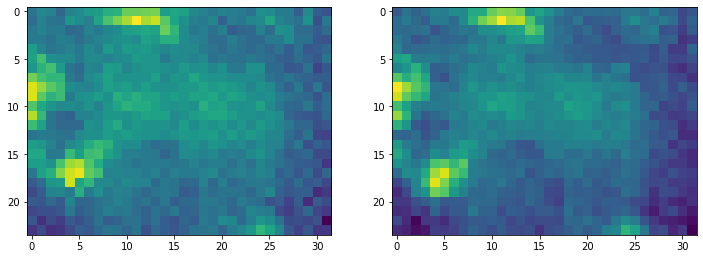

In [ ]:
gif3_mov_avg = mov_avg(gif3)
plt.rcParams['figure.figsize'] = (12,12)
plt.subplot(1,2,1)
plt.imshow(gif3[105,:,:])
plt.subplot(1,2,2)
plt.imshow(gif3_mov_avg[105,:,:])
plt.show()

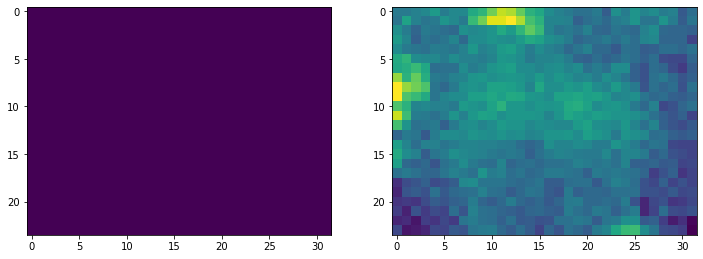

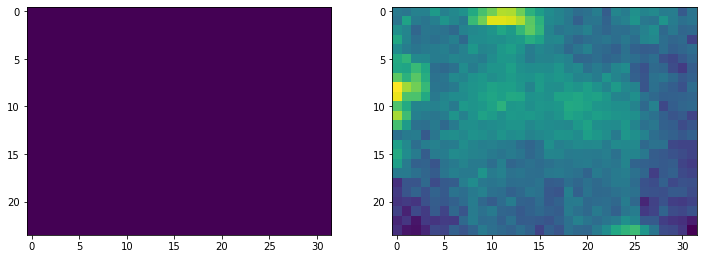

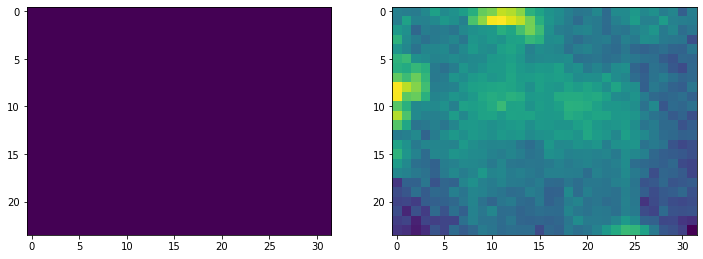

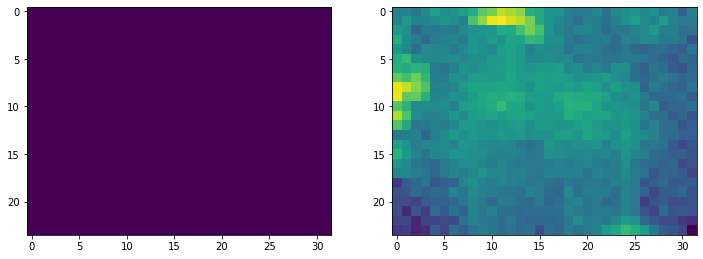

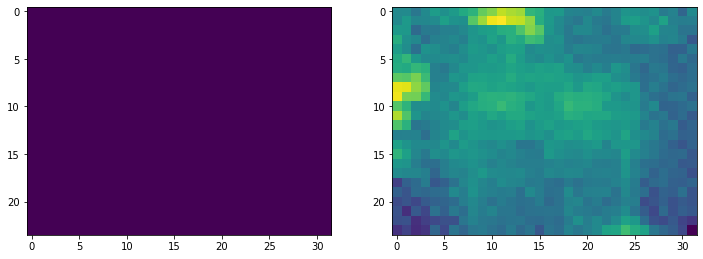

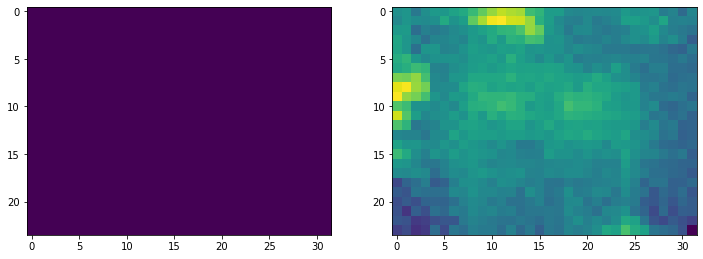

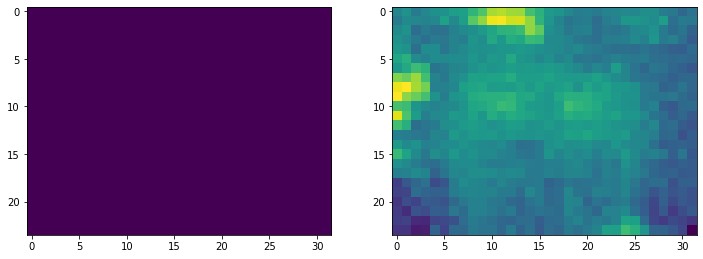

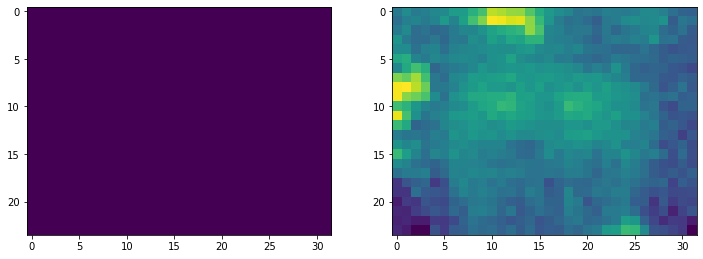

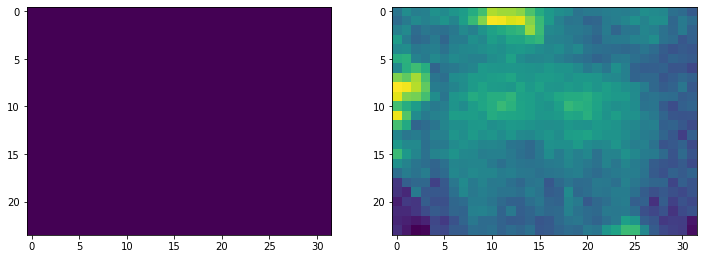

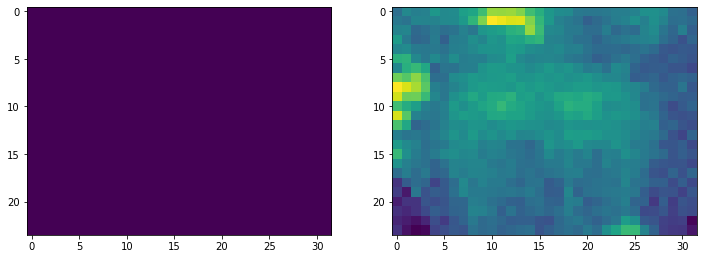

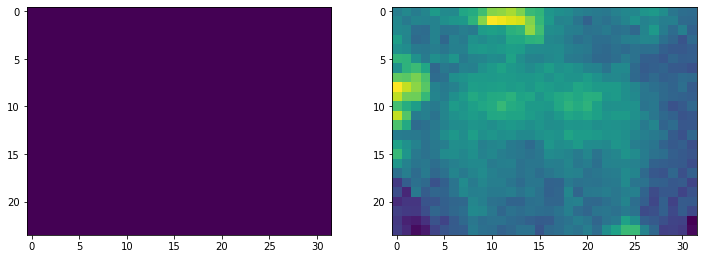

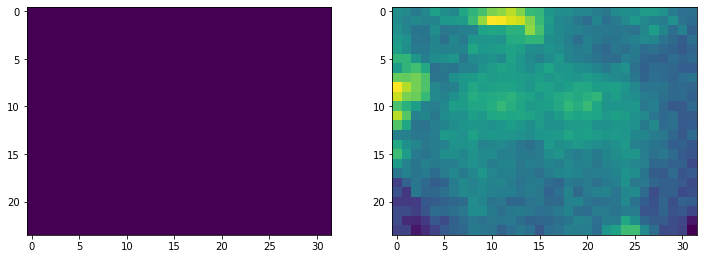

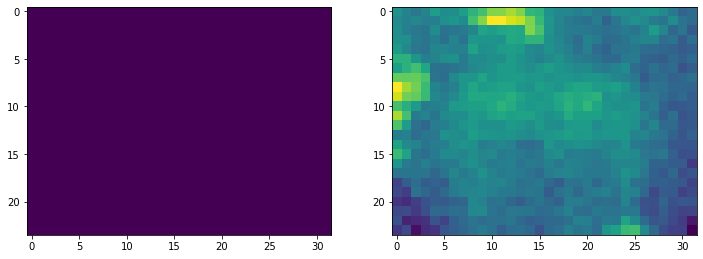

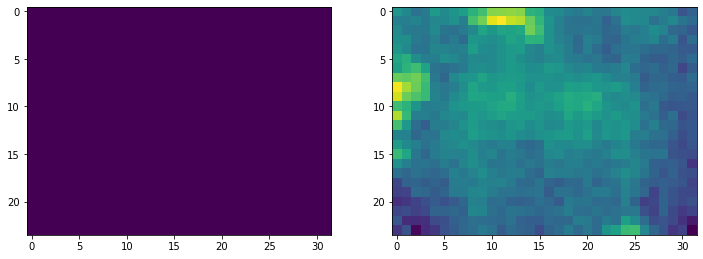

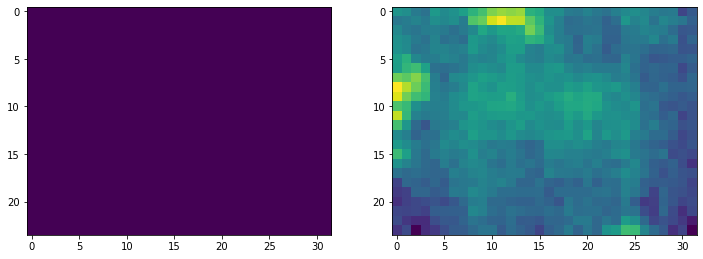

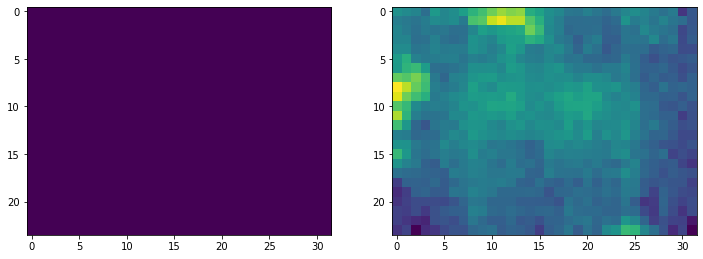

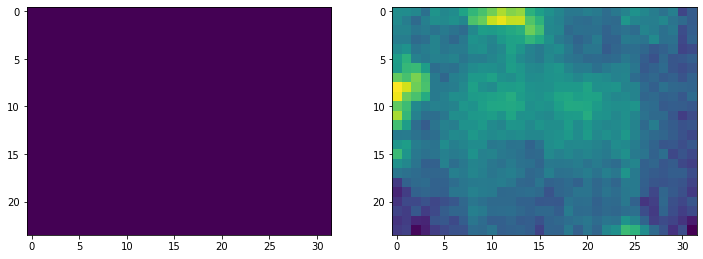

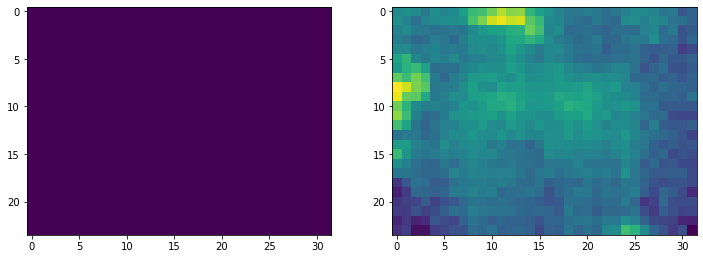

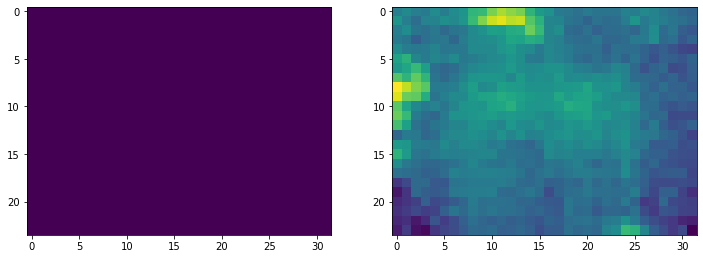

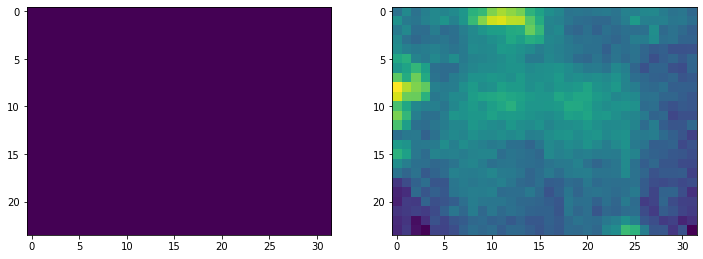

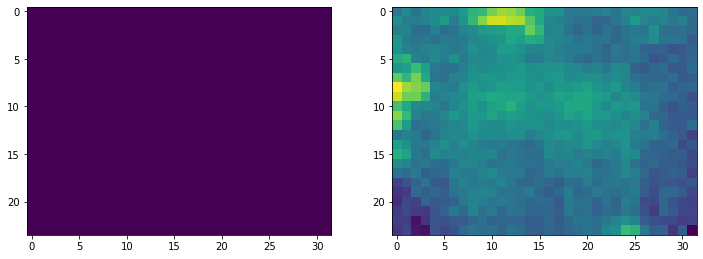

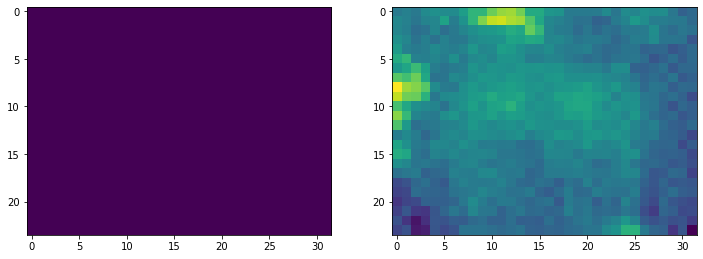

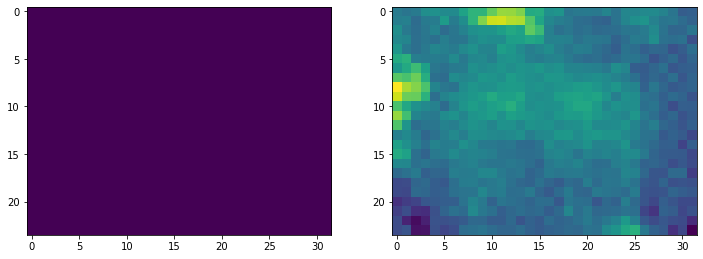

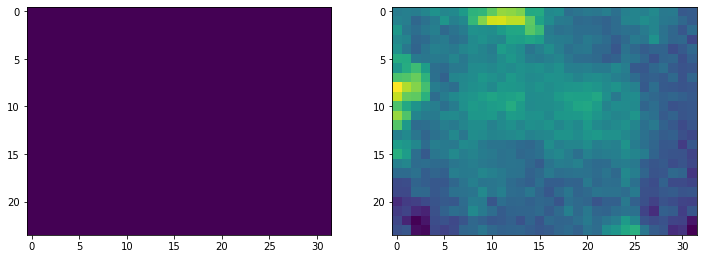

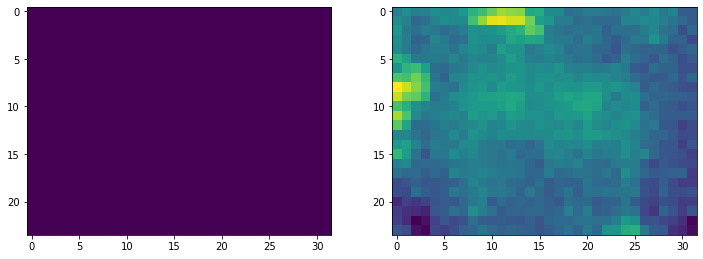

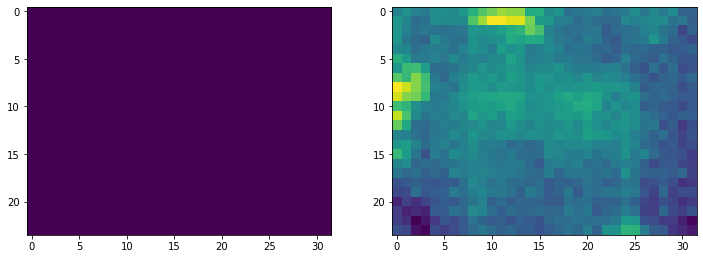

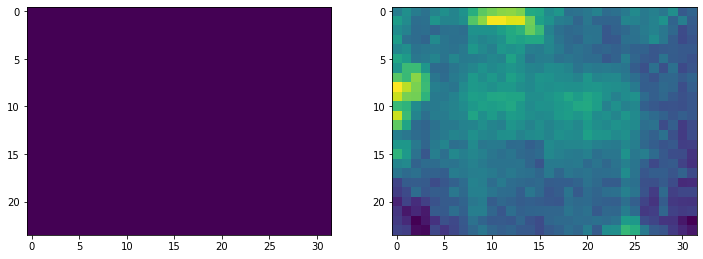

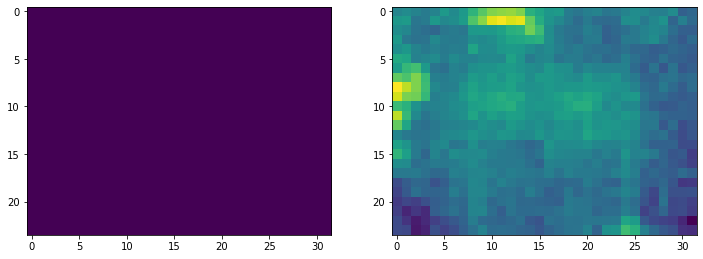

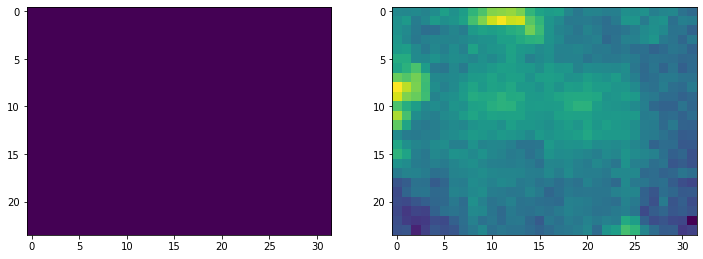

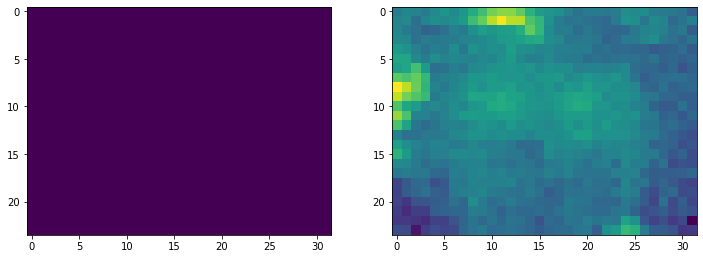

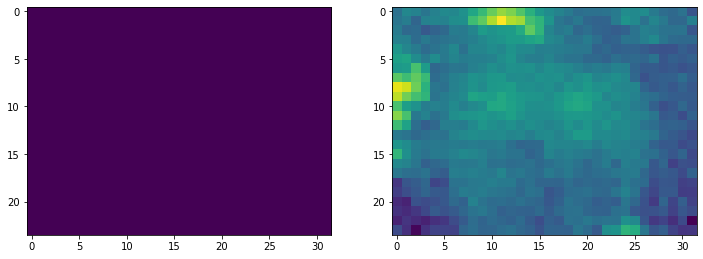

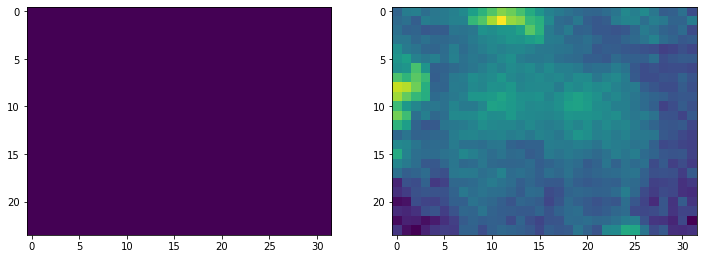

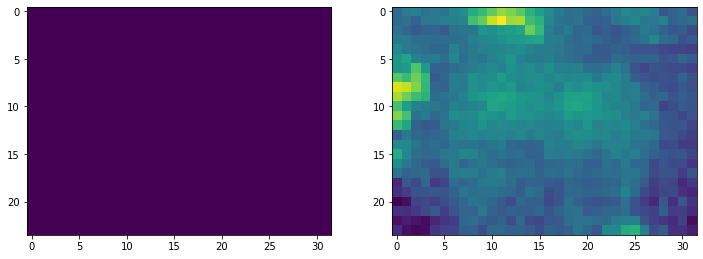

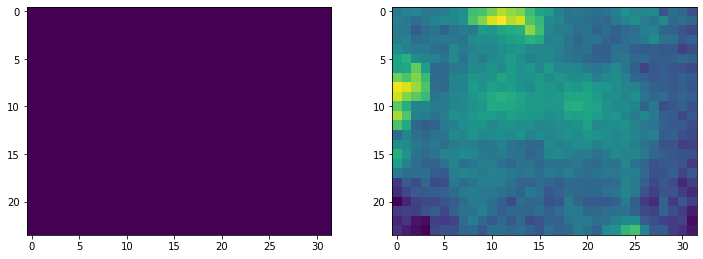

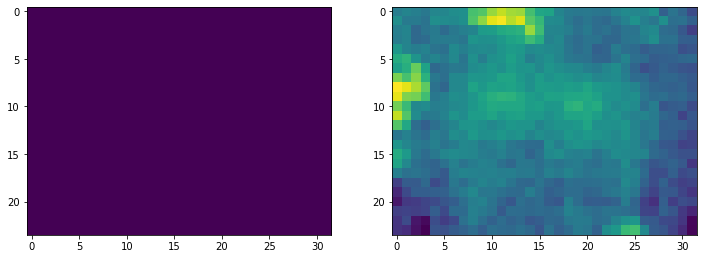

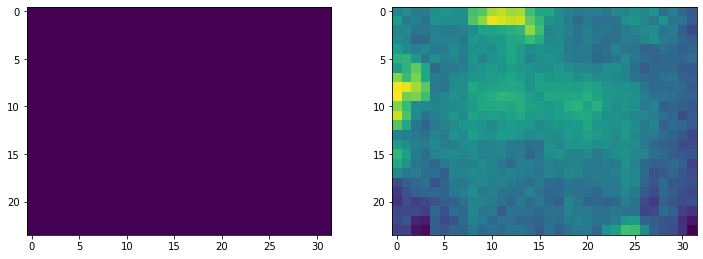

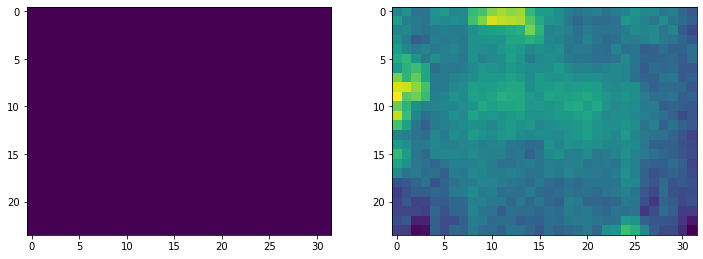

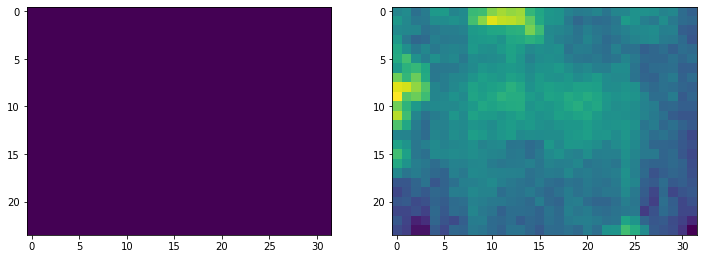

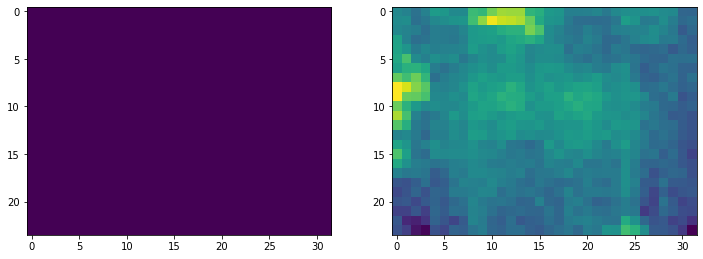

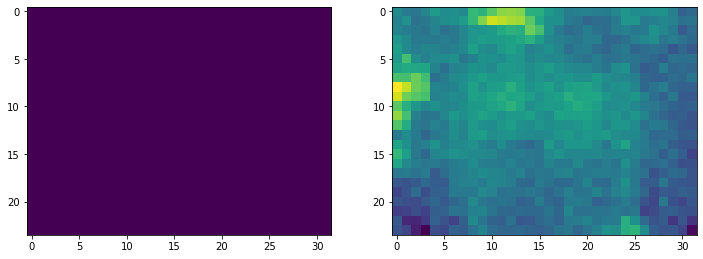

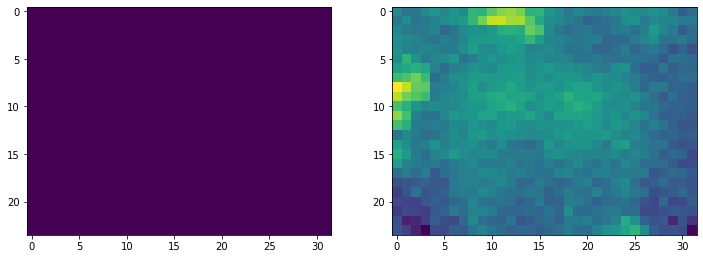

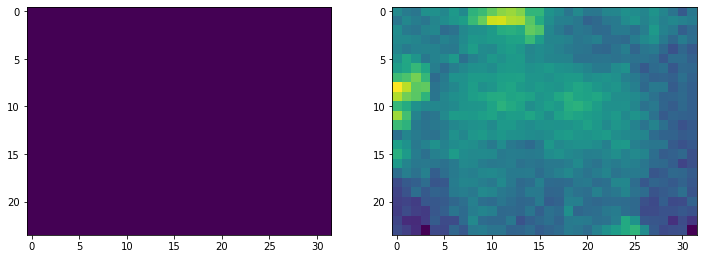

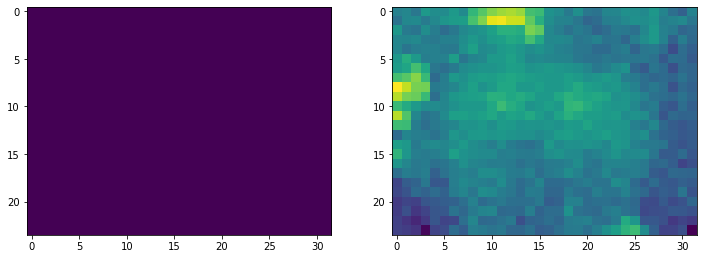

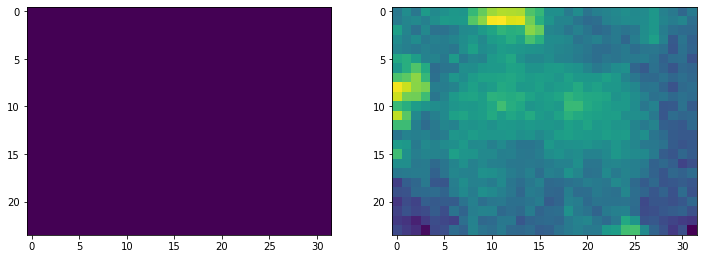

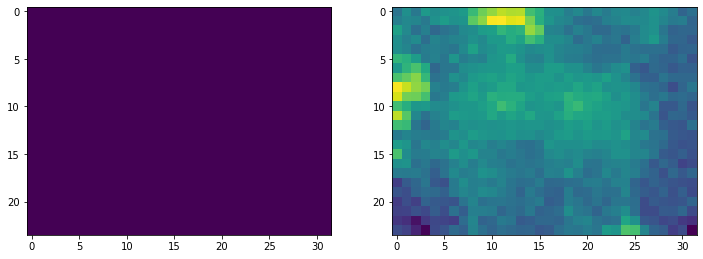

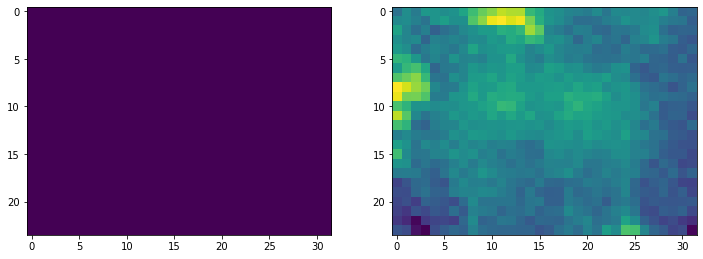

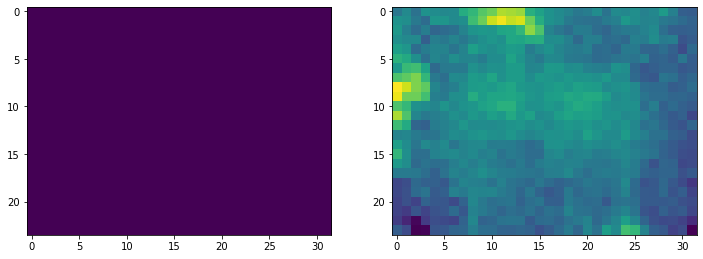

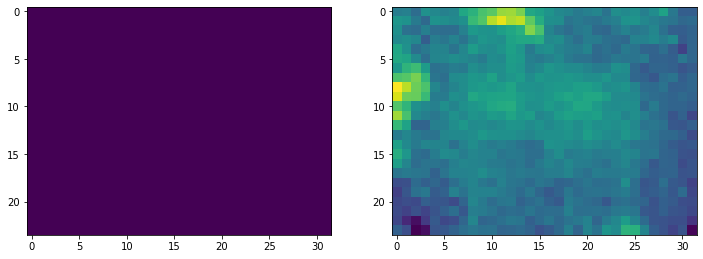

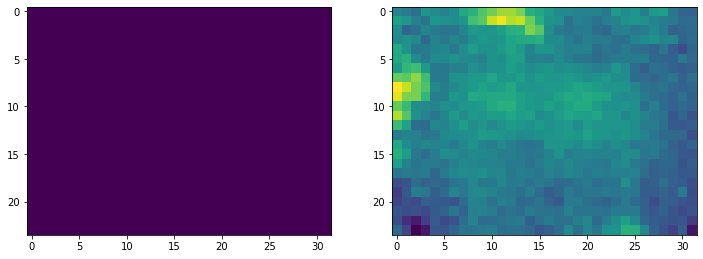

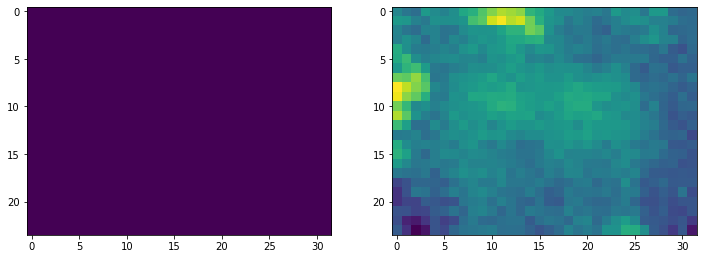

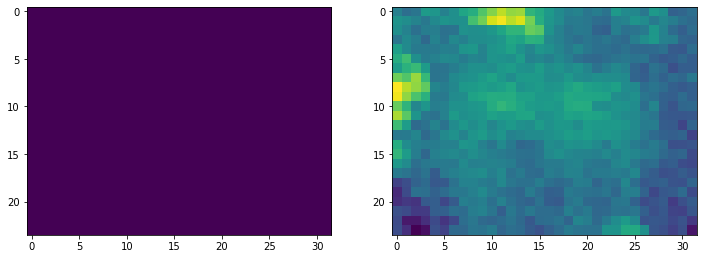

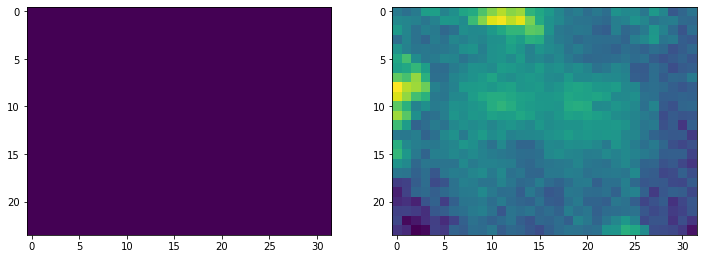

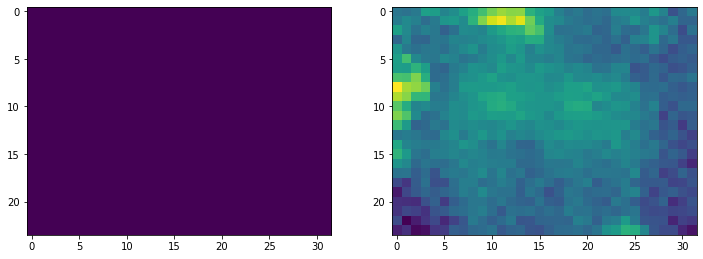

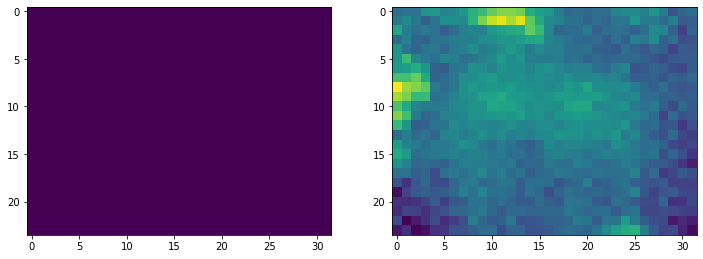

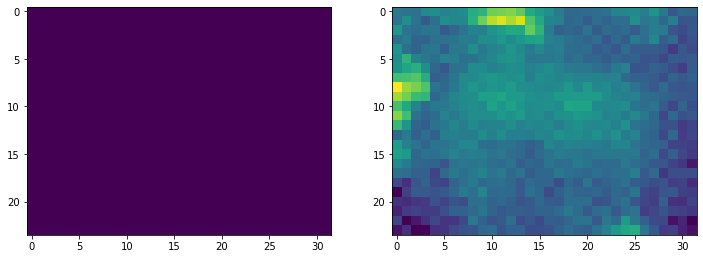

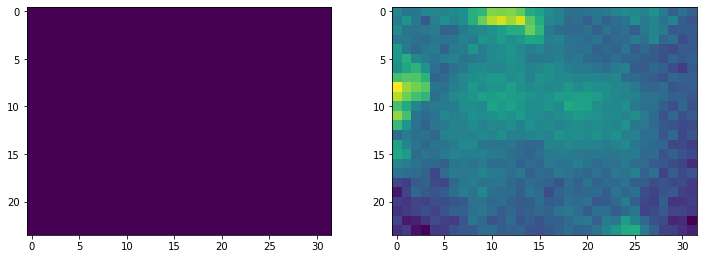

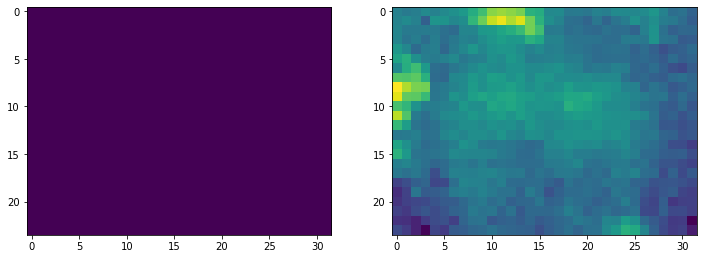

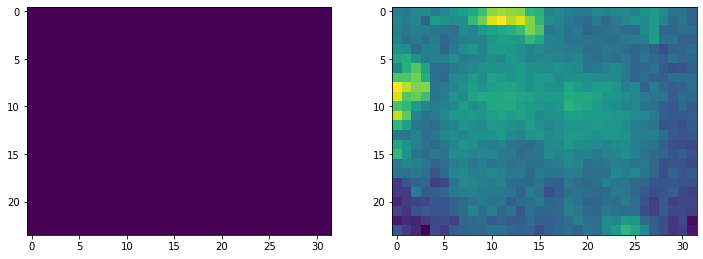

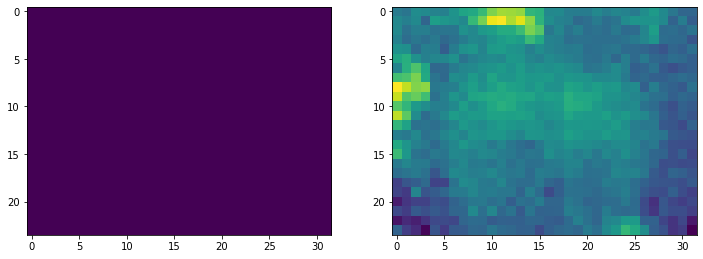

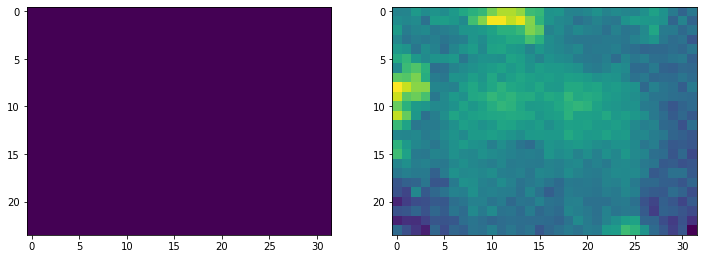

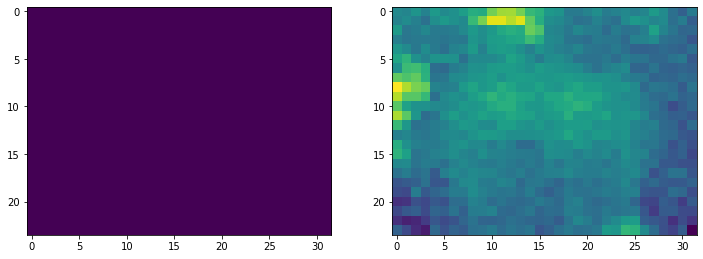

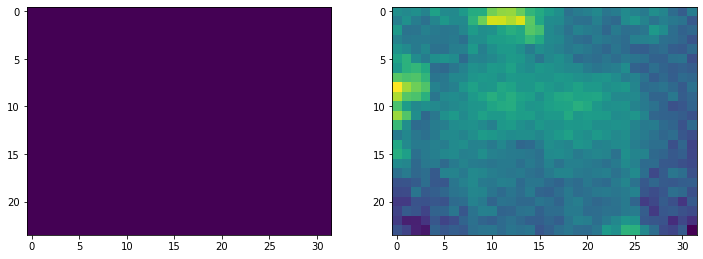

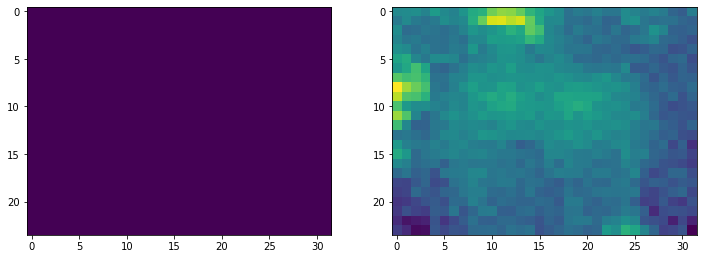

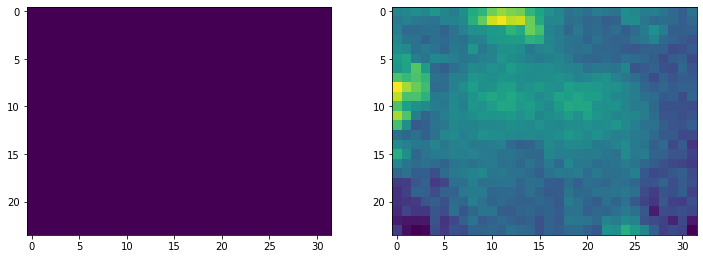

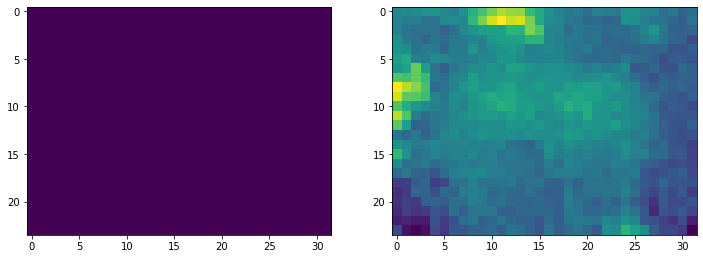

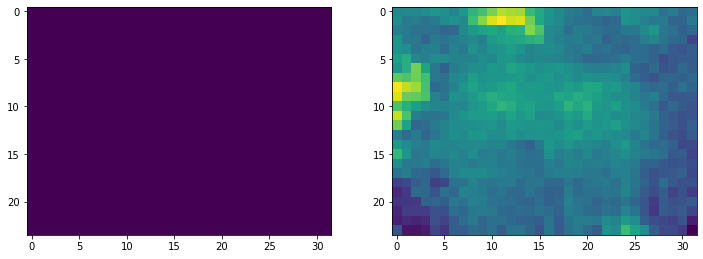

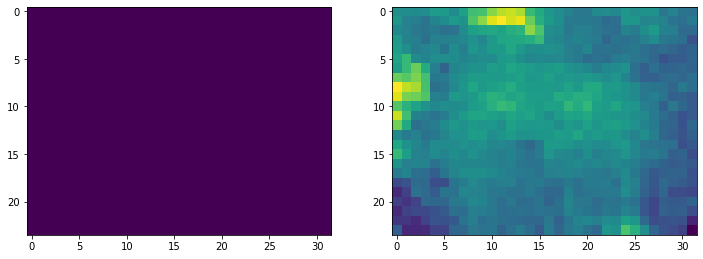

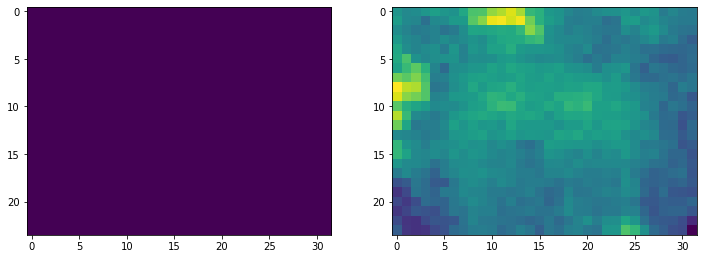

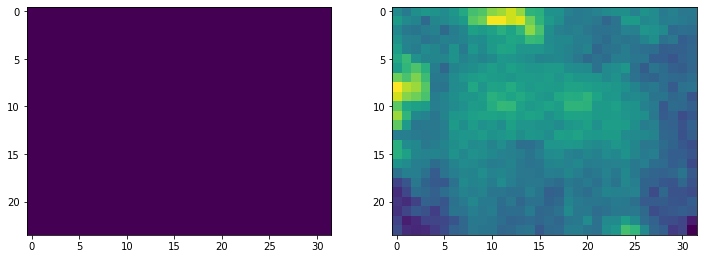

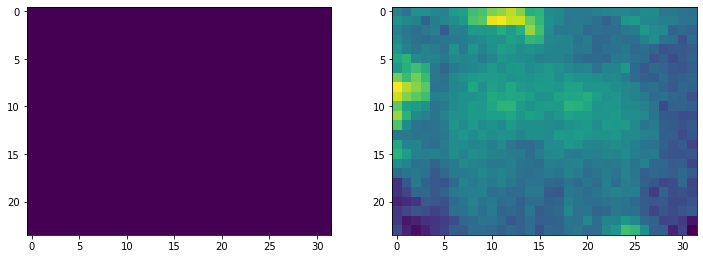

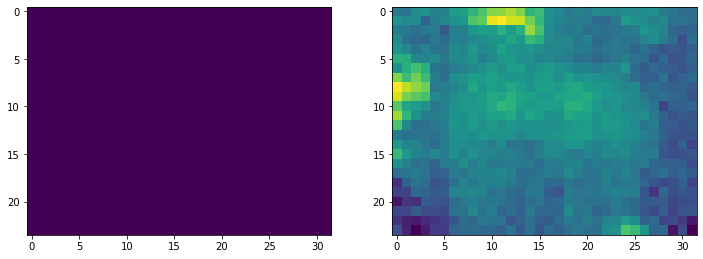

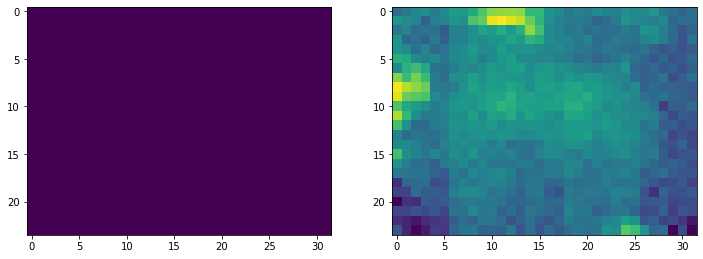

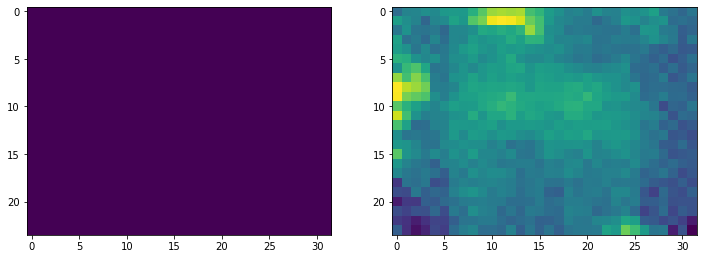

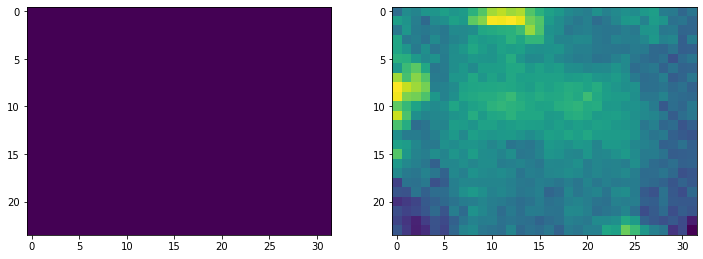

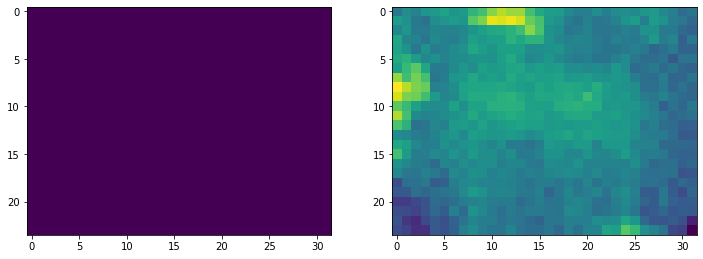

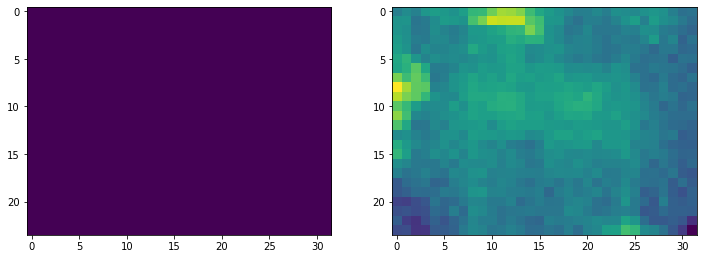

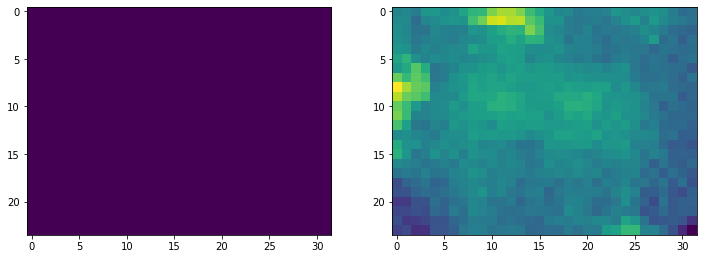

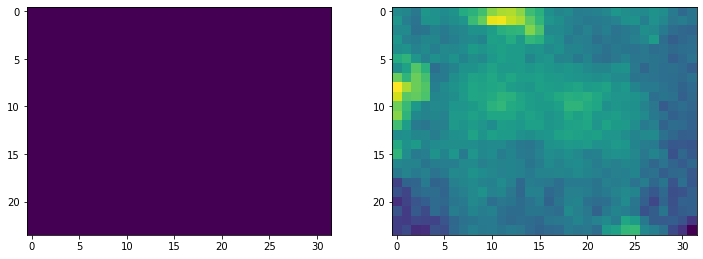

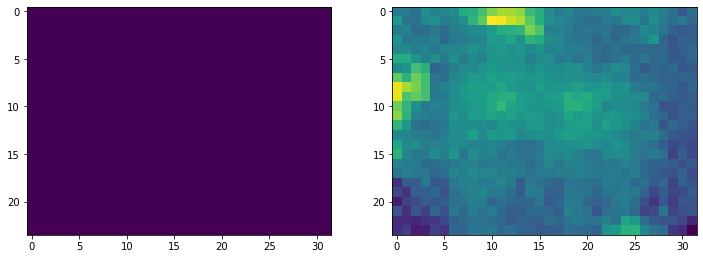

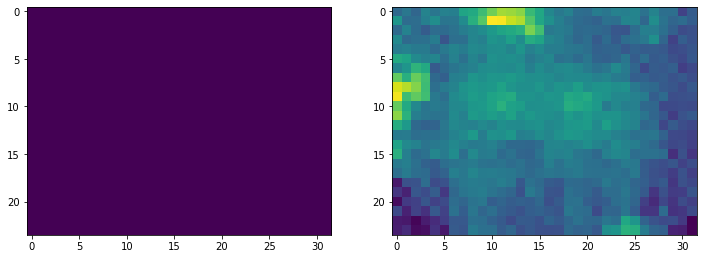

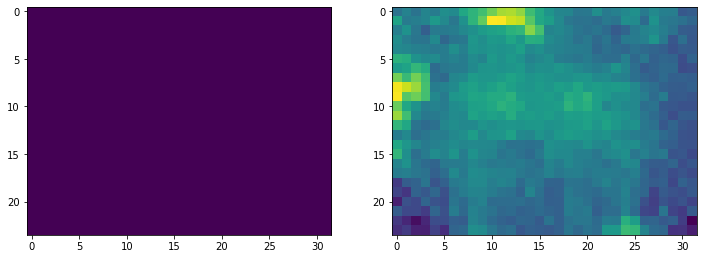

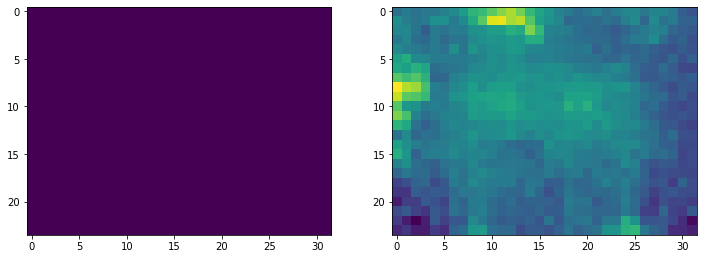

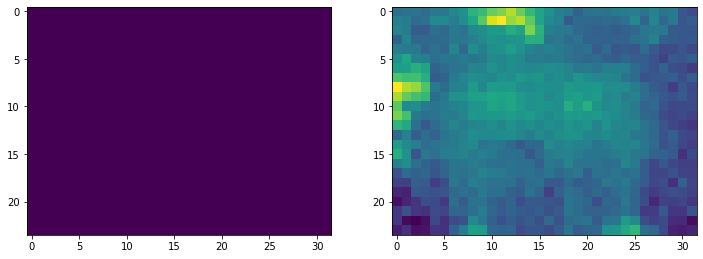

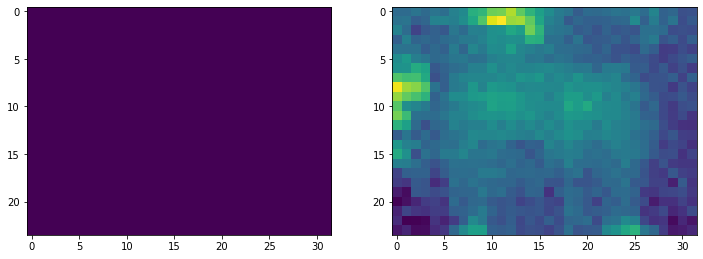

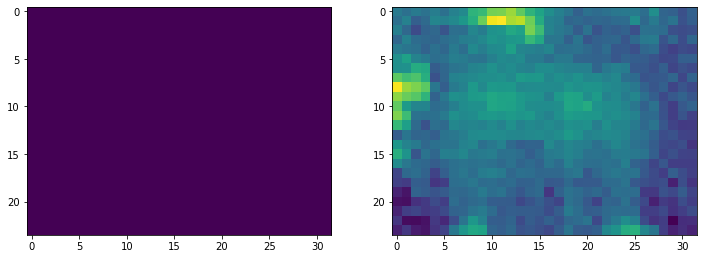

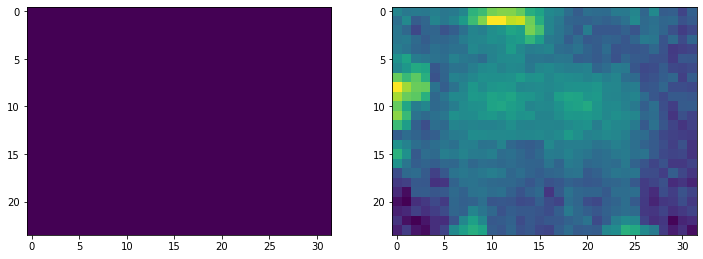

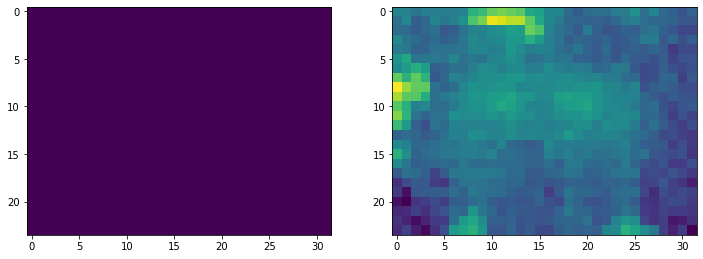

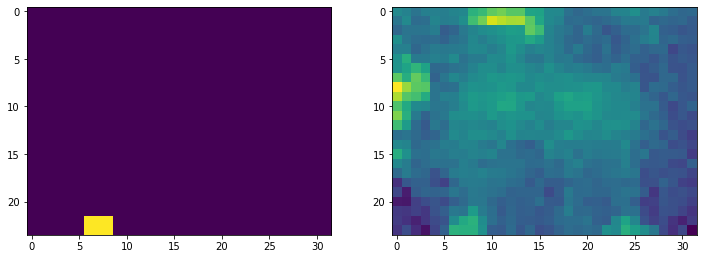

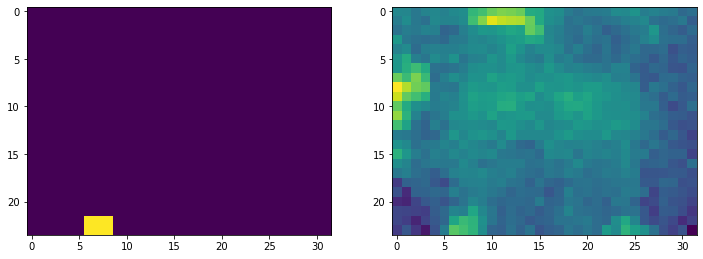

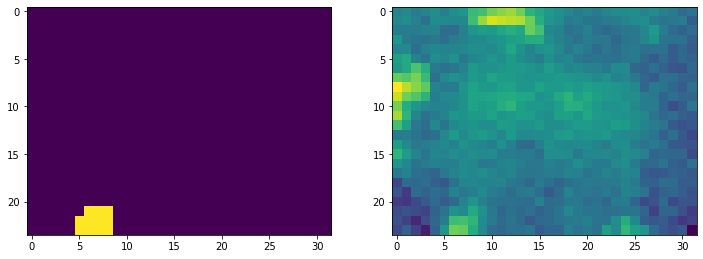

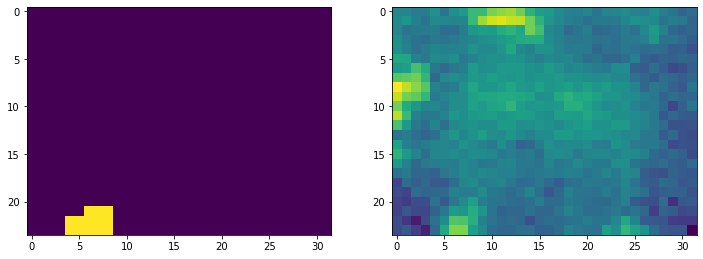

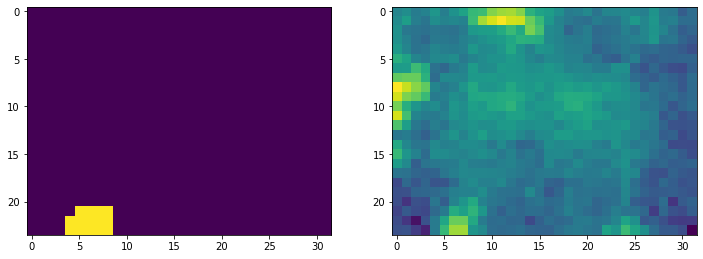

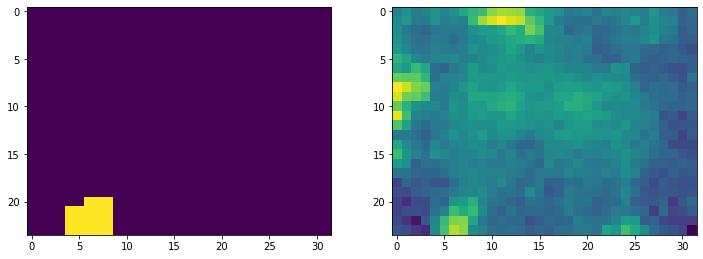

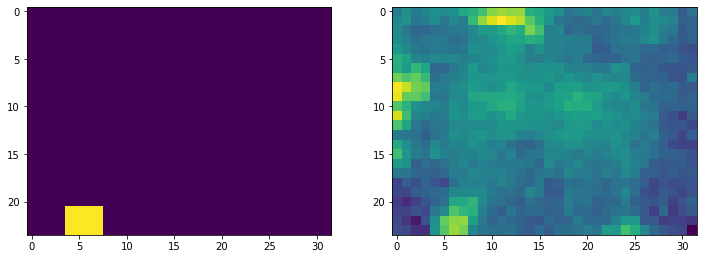

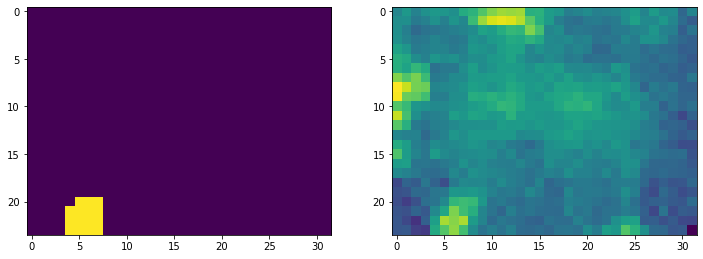

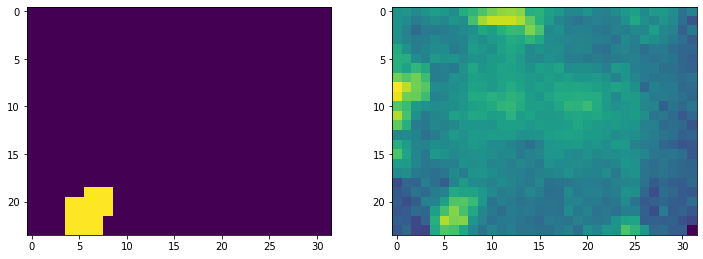

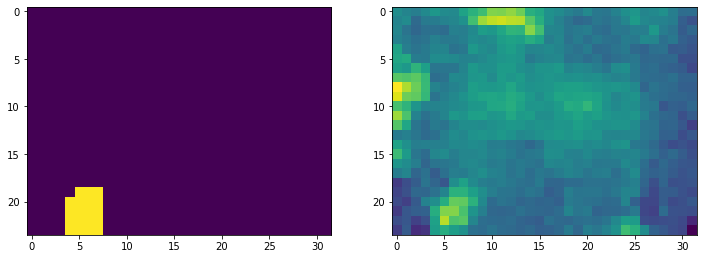

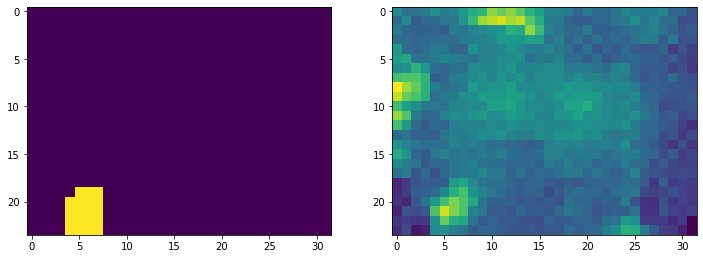

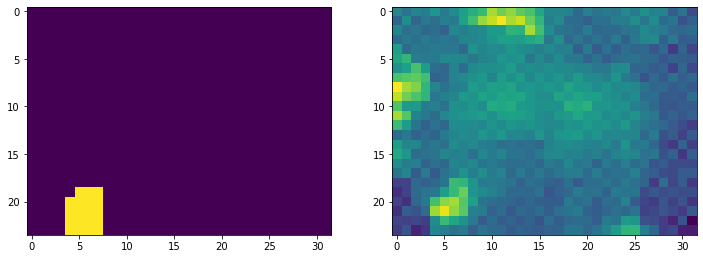

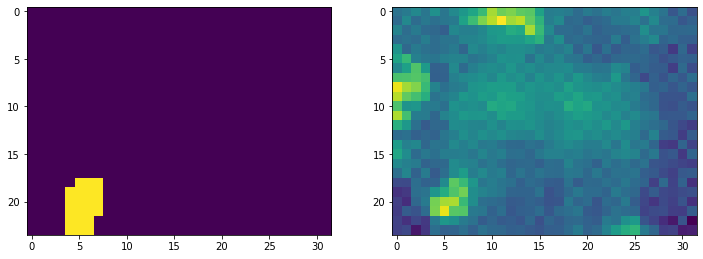

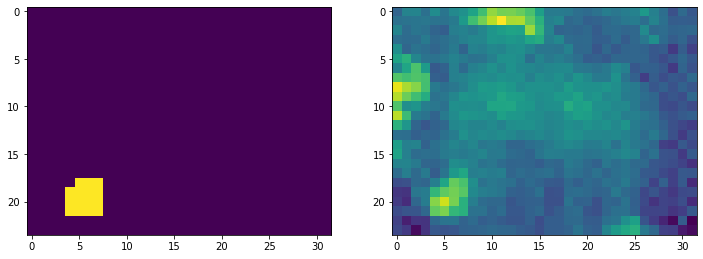

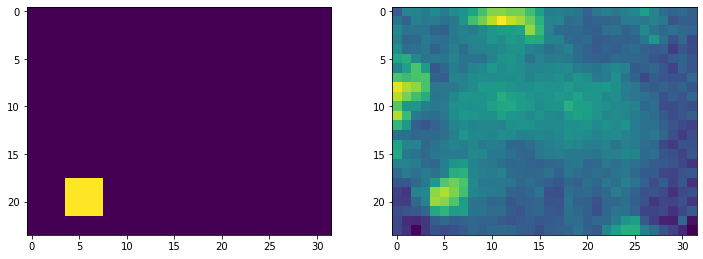

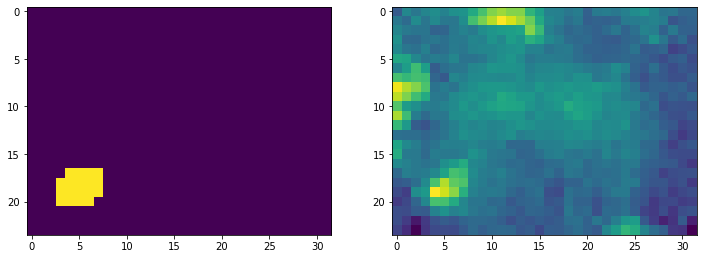

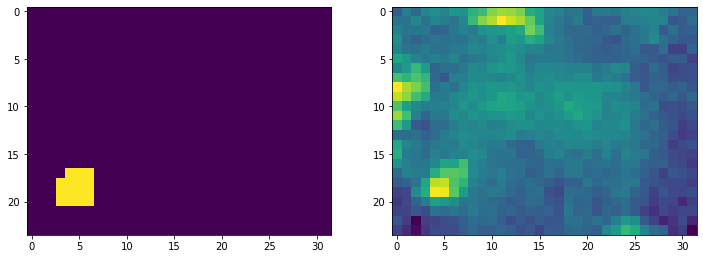

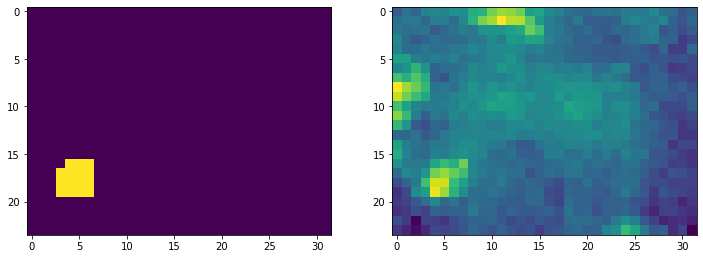

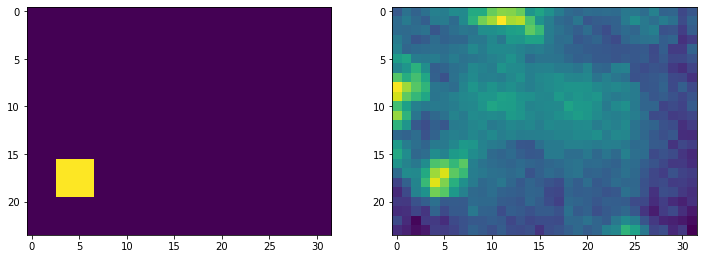

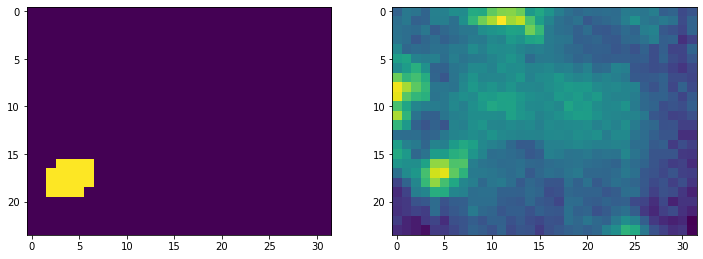

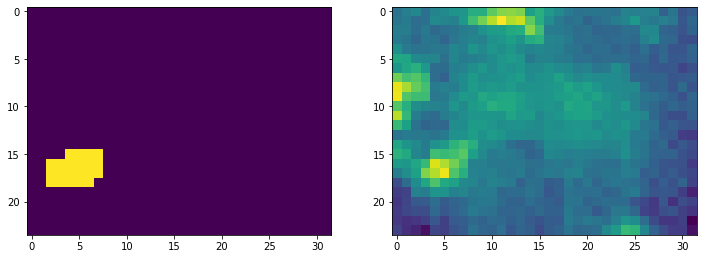

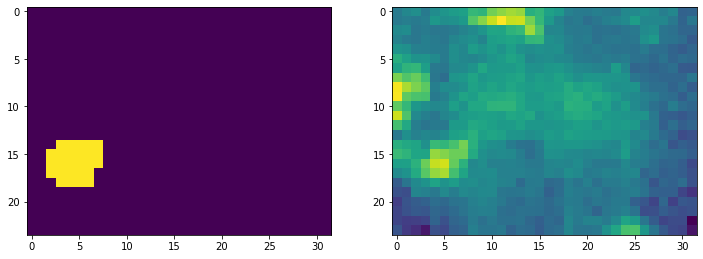

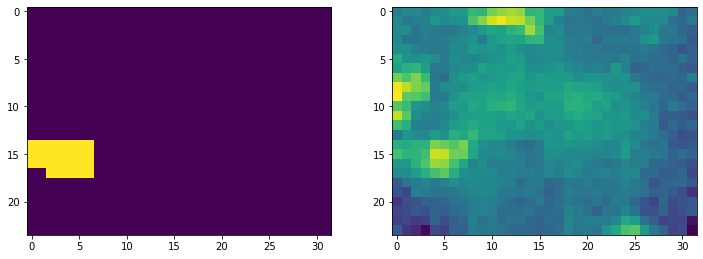

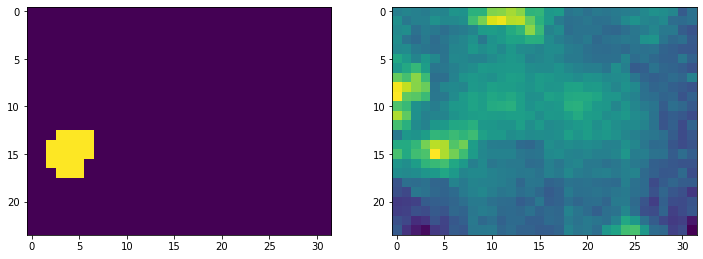

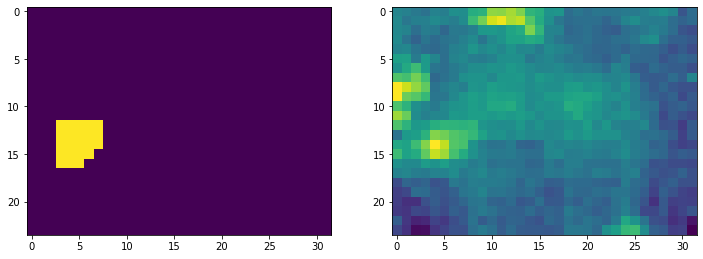

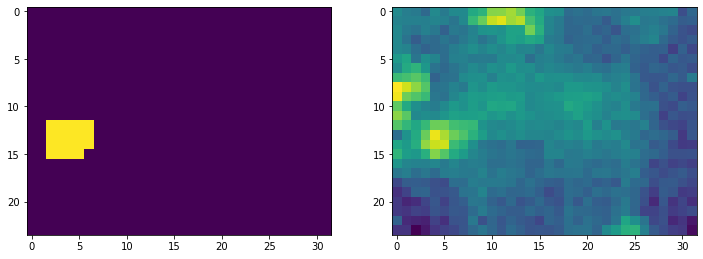

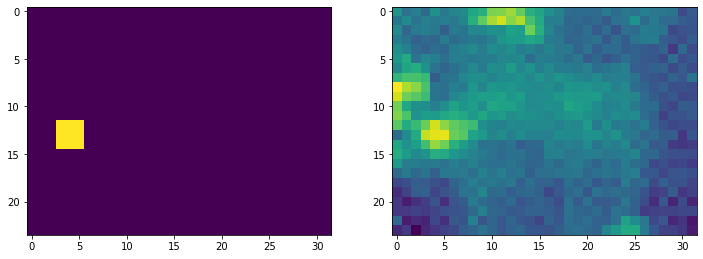

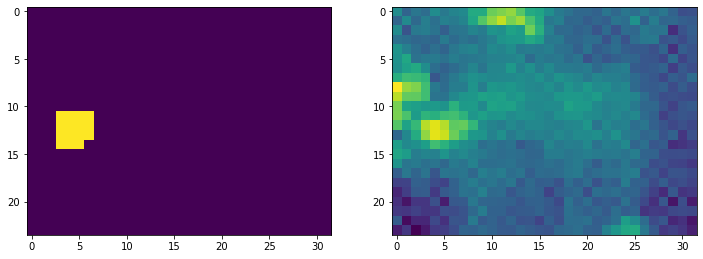

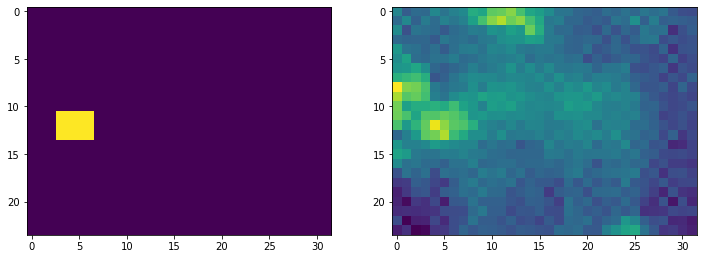

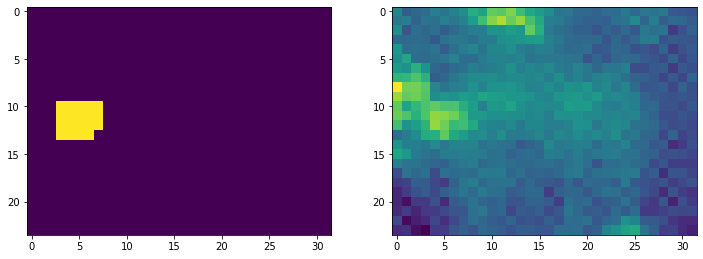

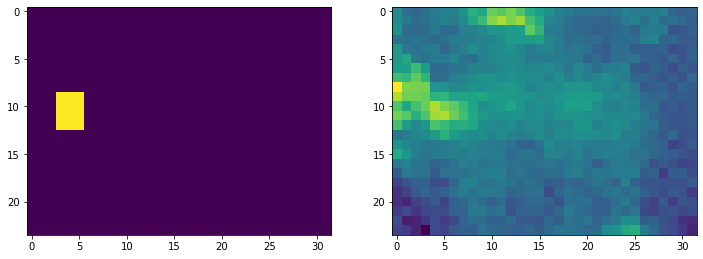

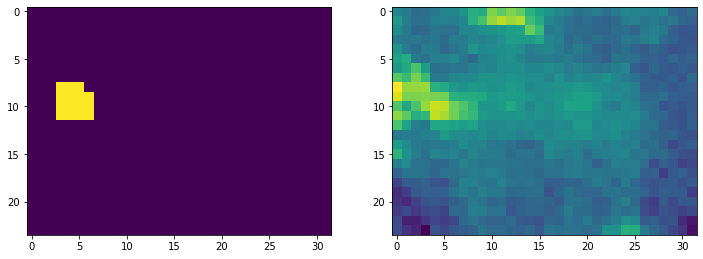

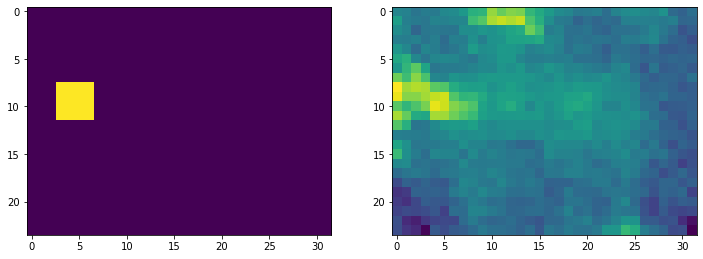

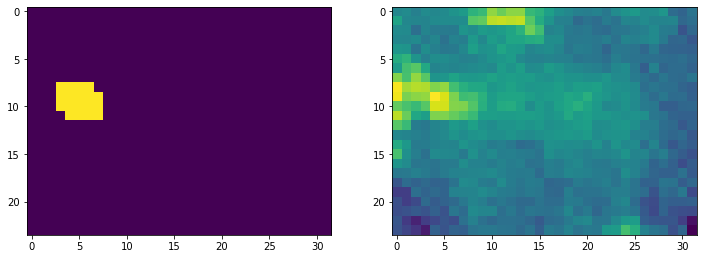

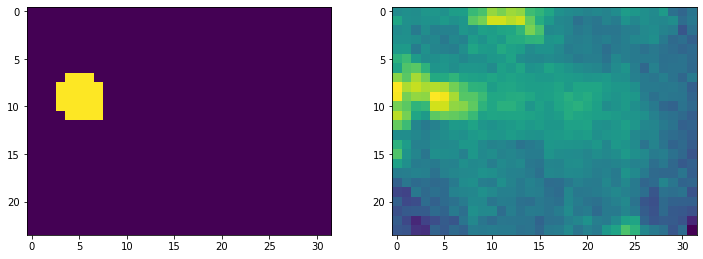

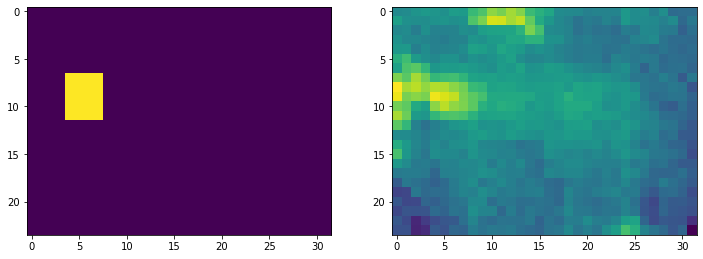

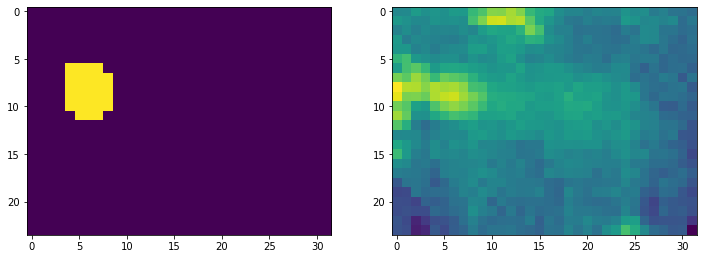

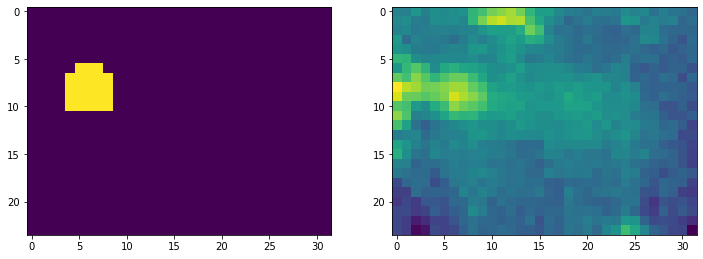

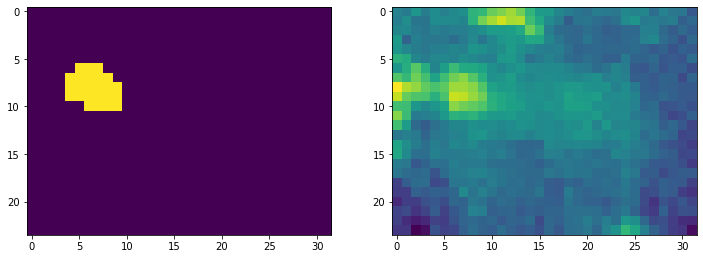

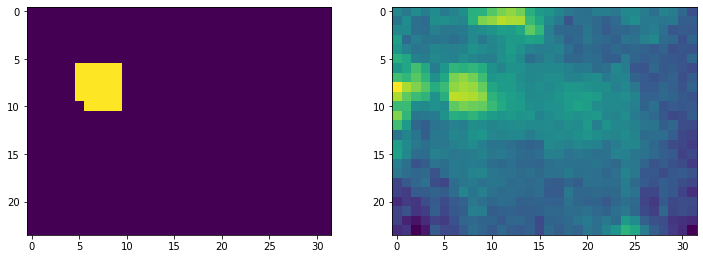

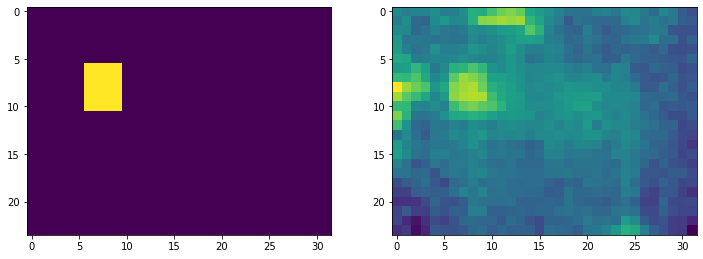

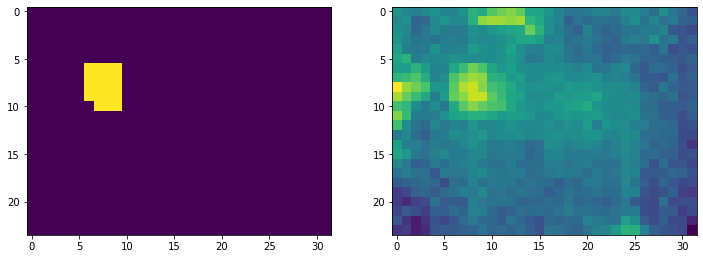

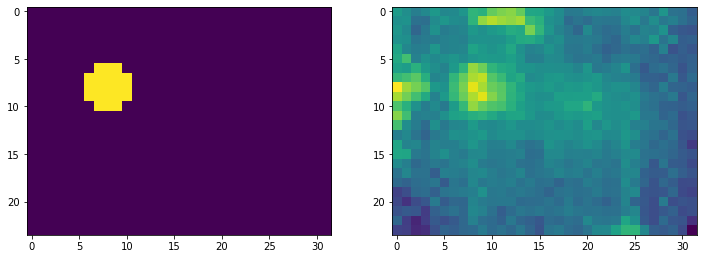

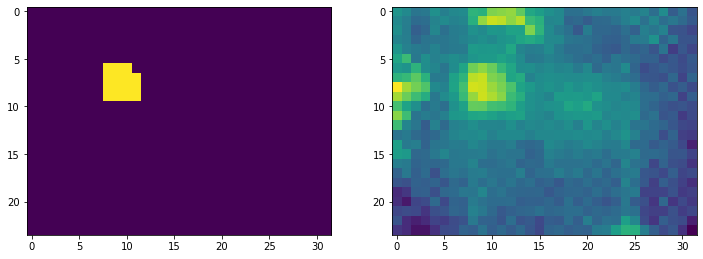

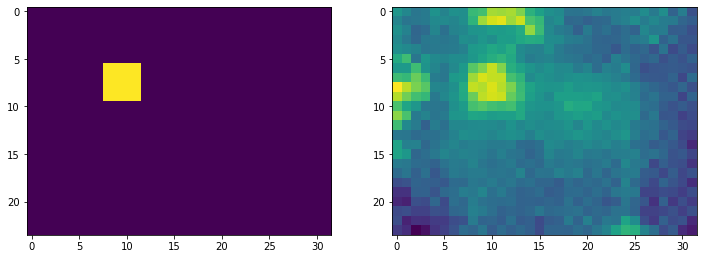

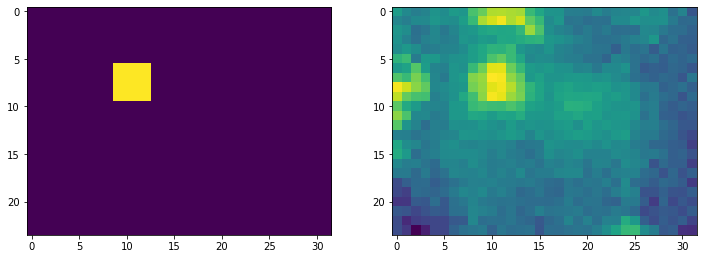

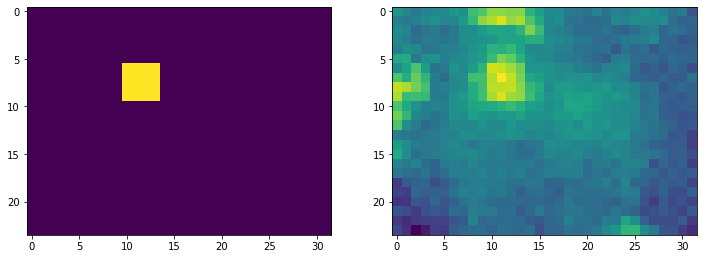

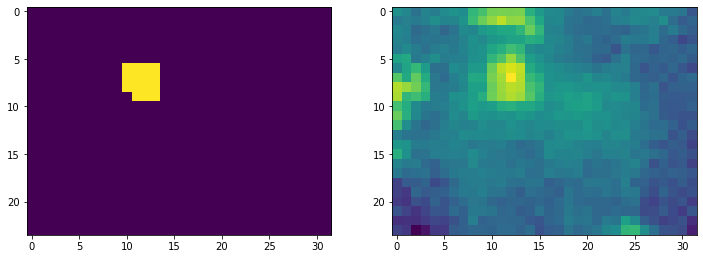

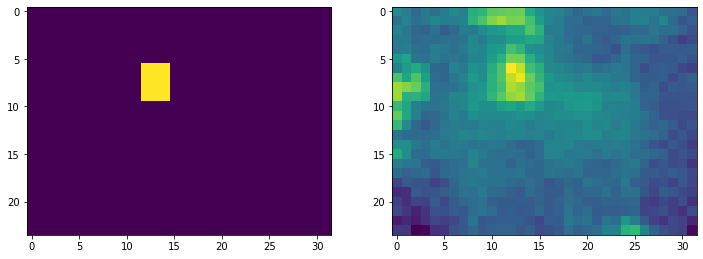

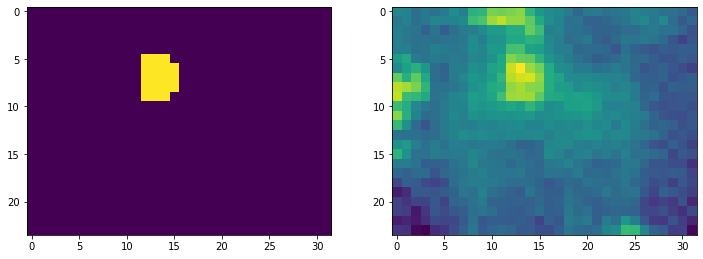

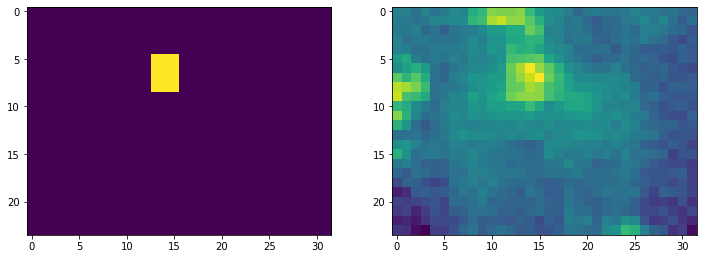

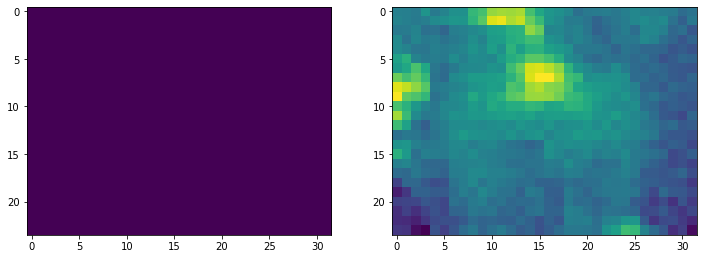

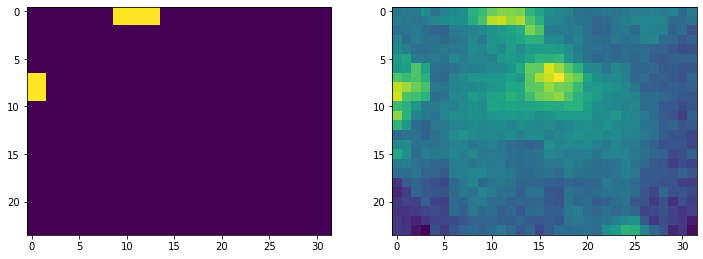

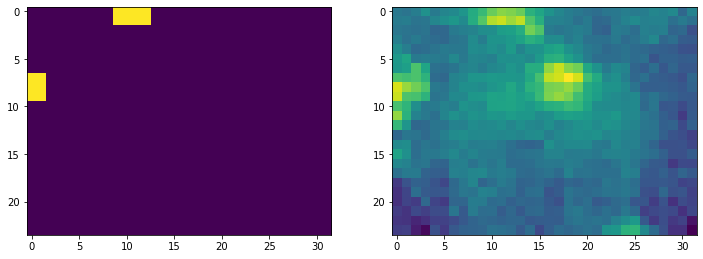

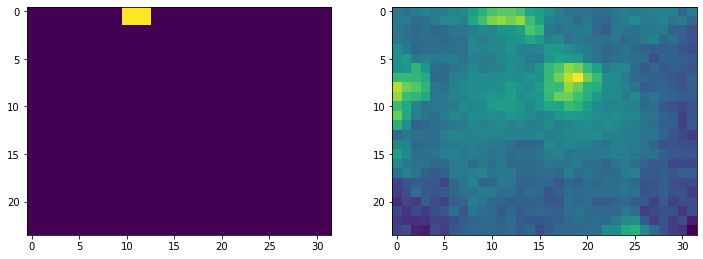

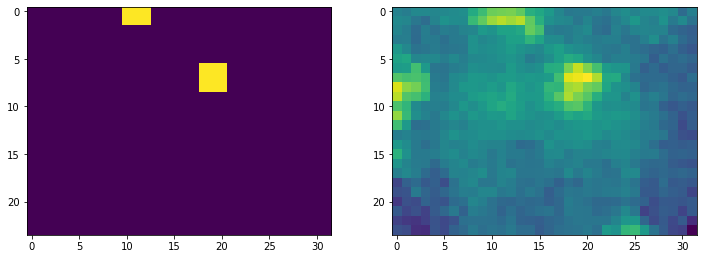

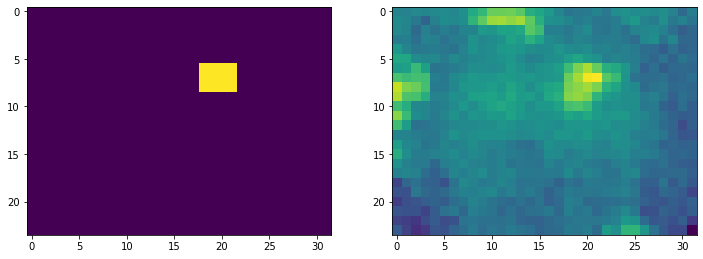

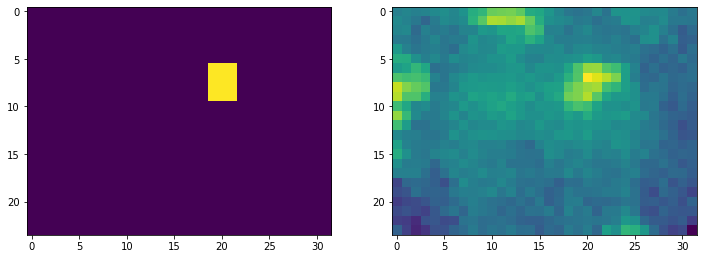

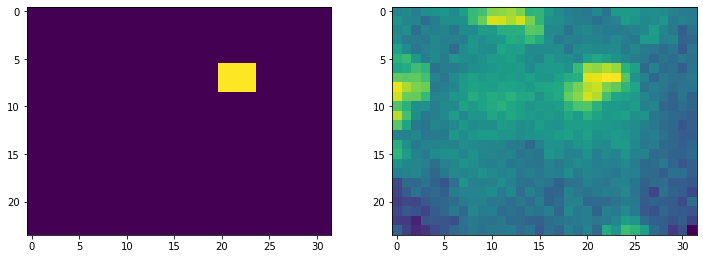

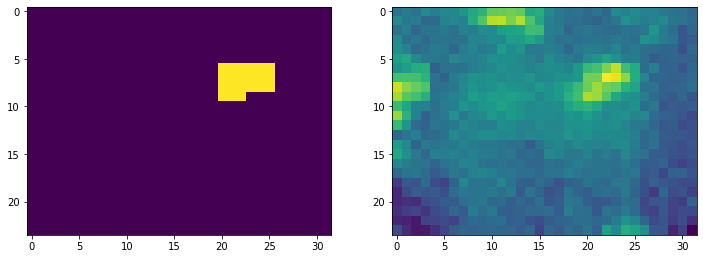

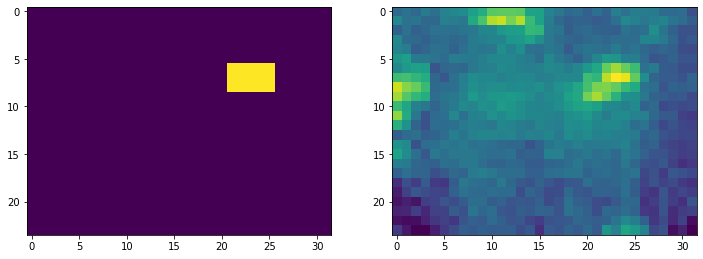

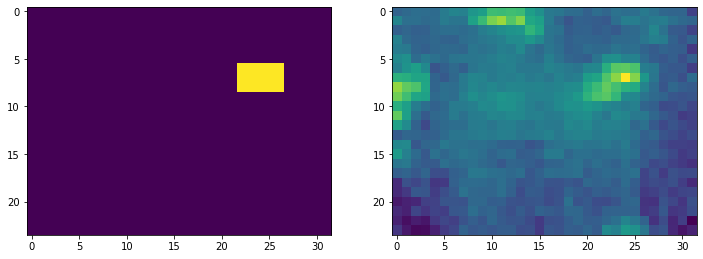

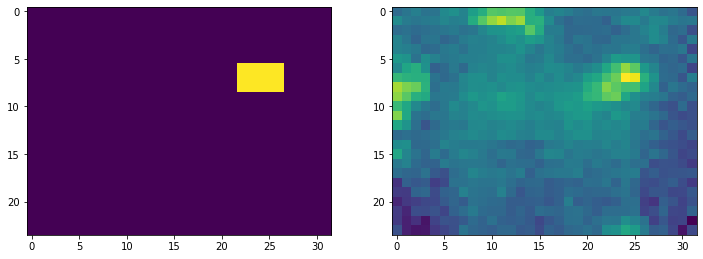

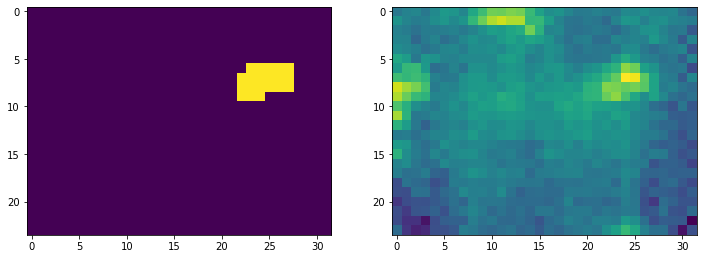

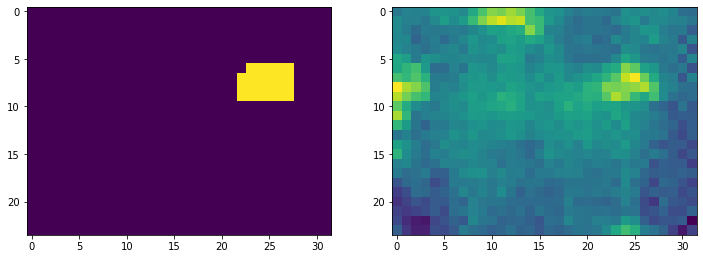

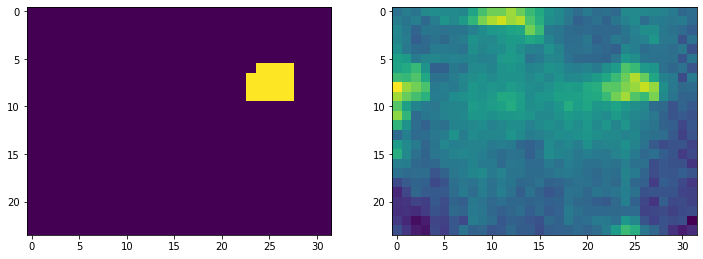

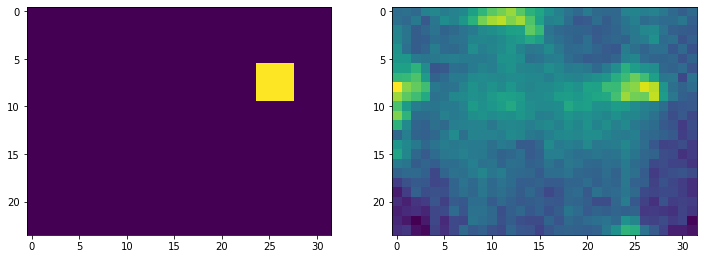

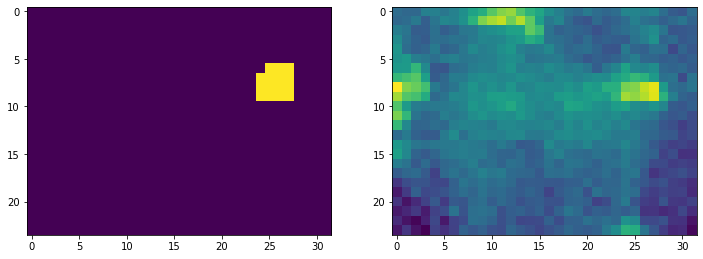

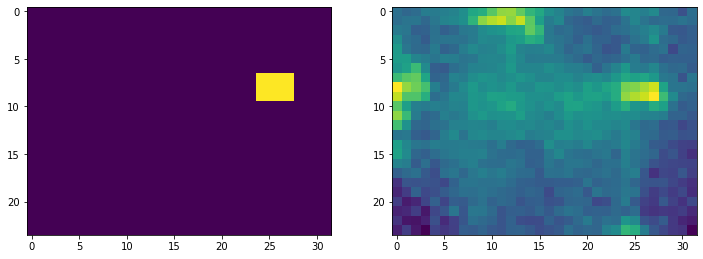

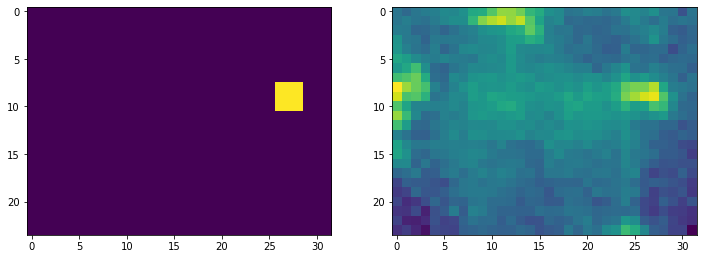

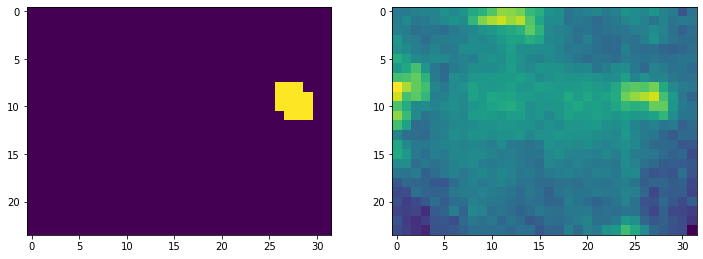

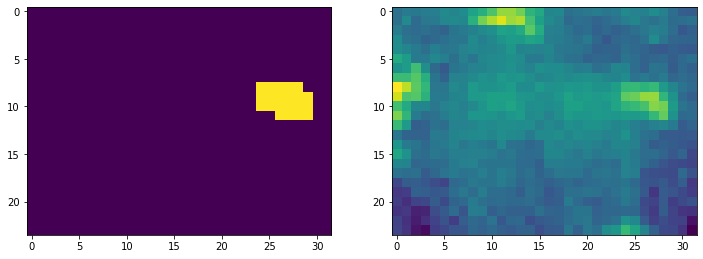

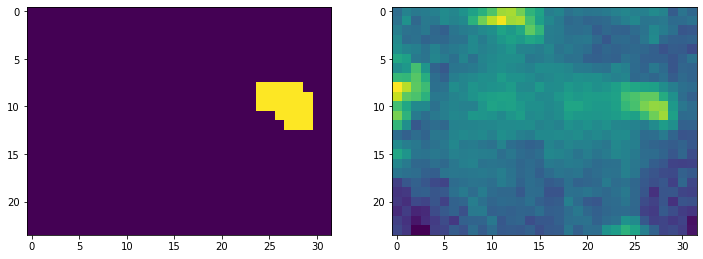

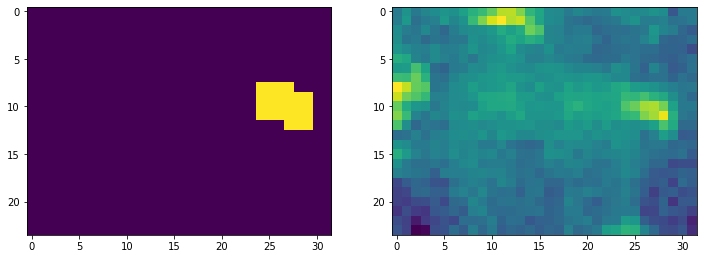

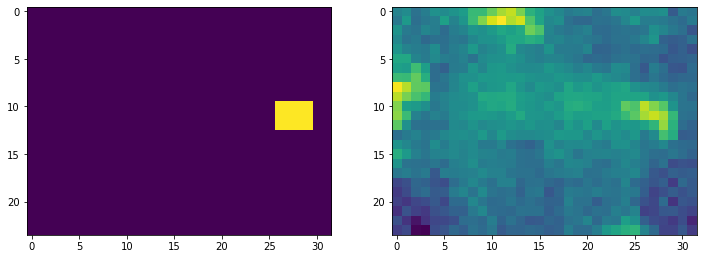

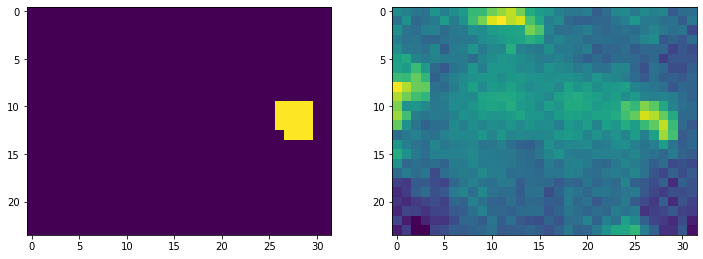

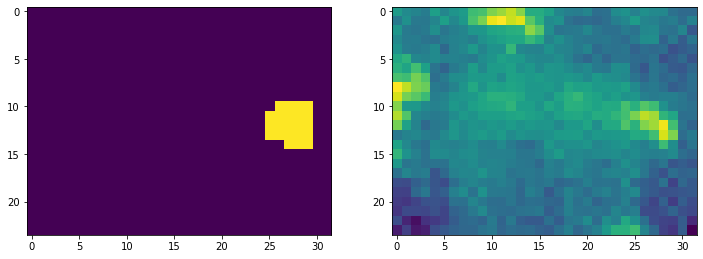

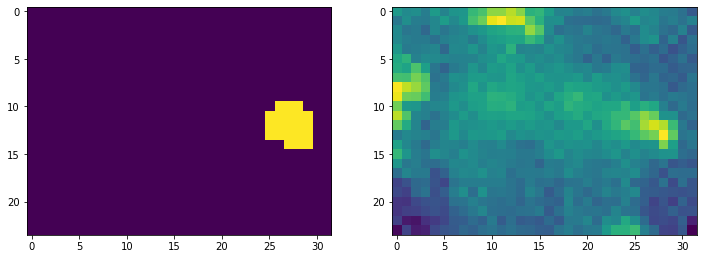

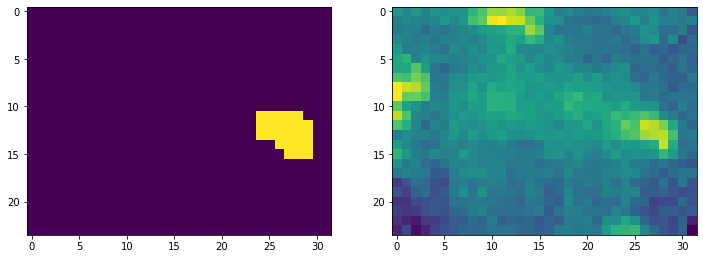

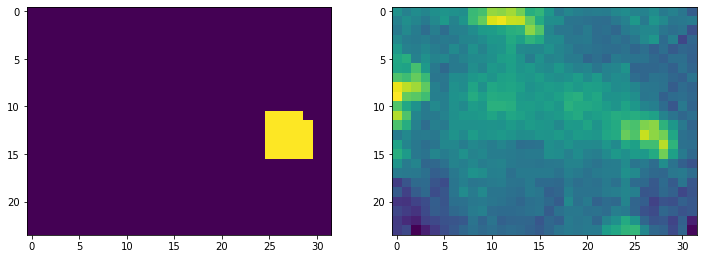

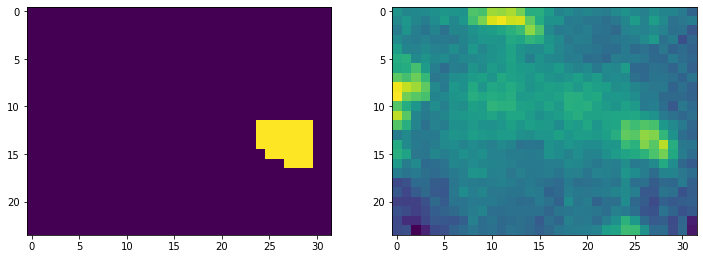

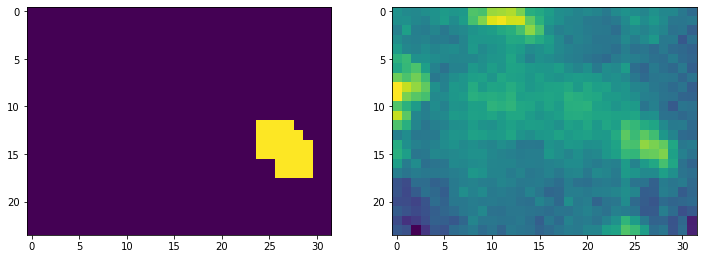

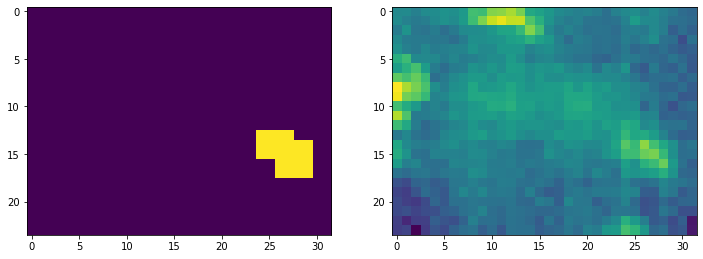

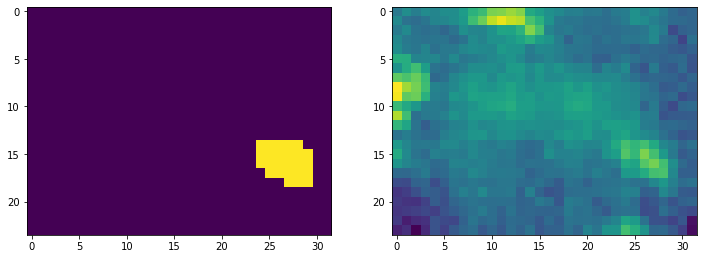

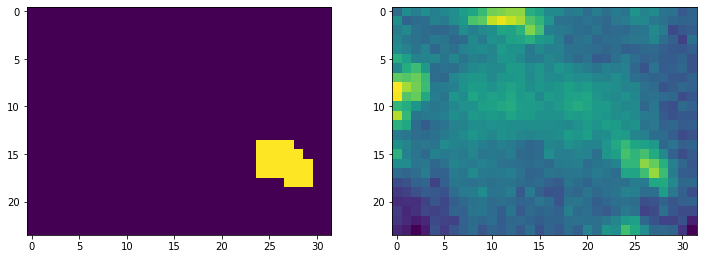

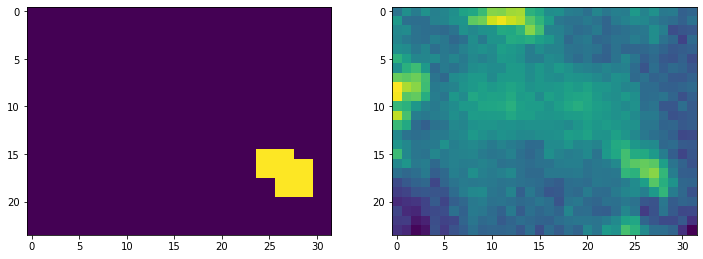

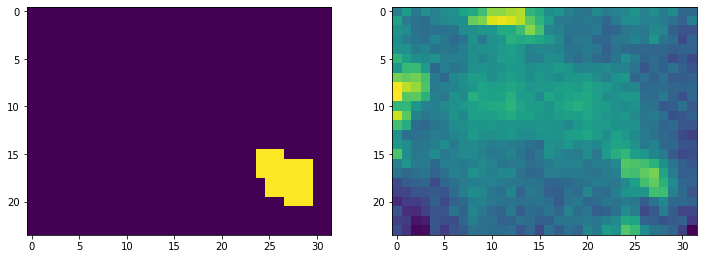

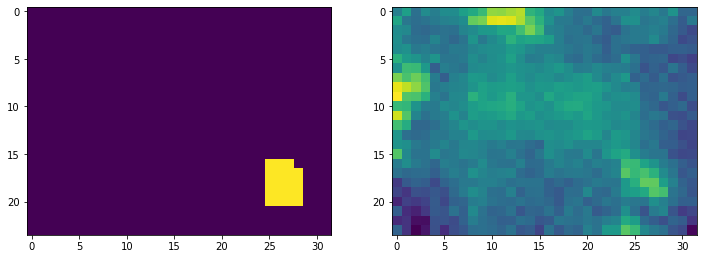

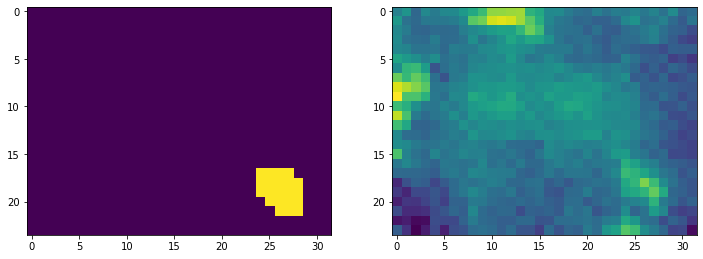

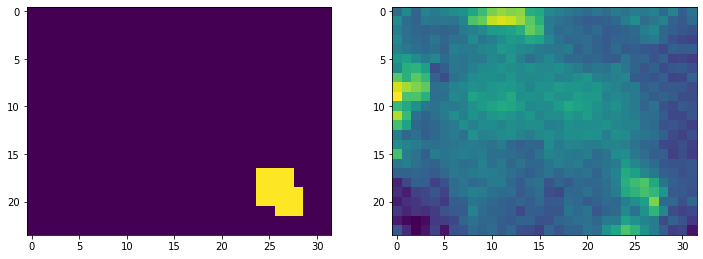

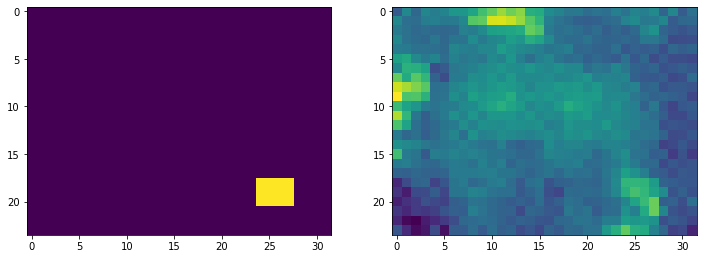

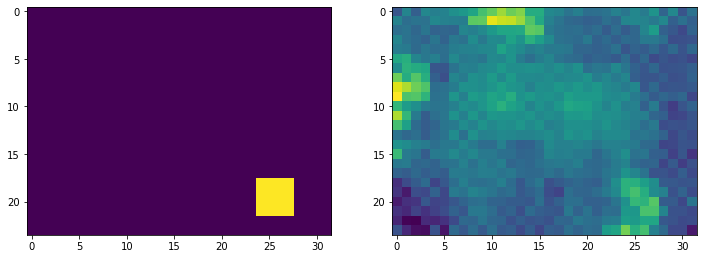

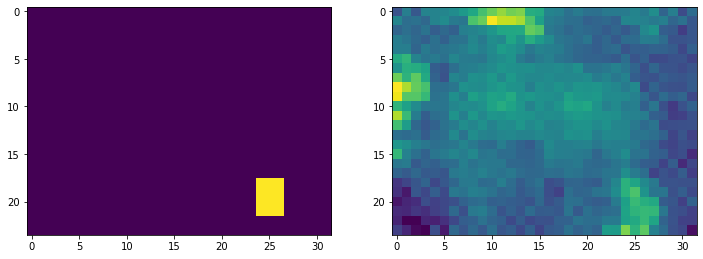

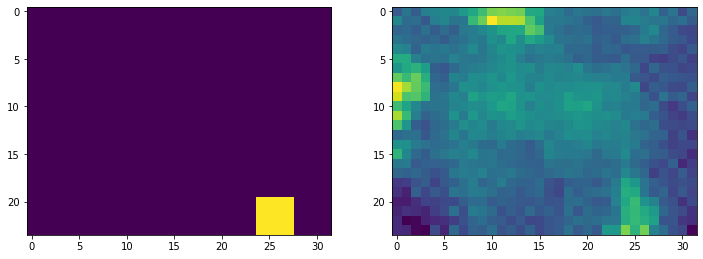

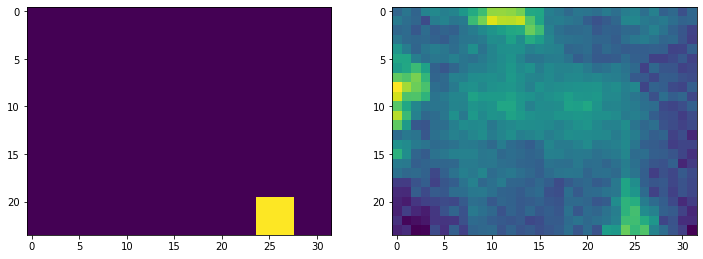

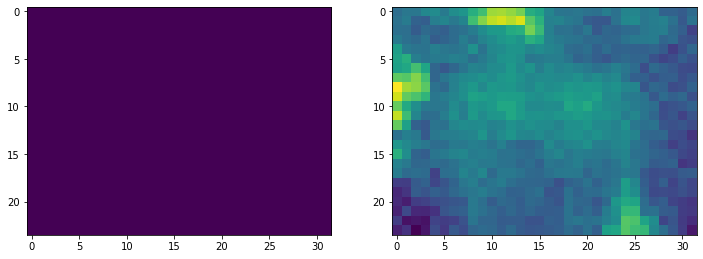

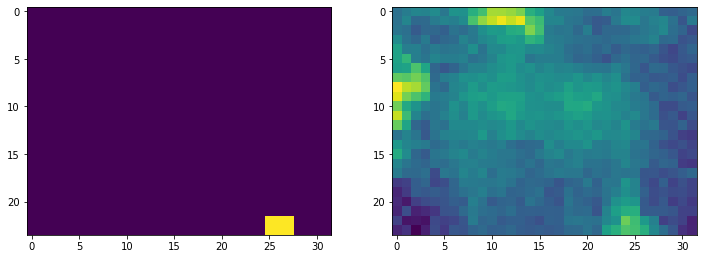

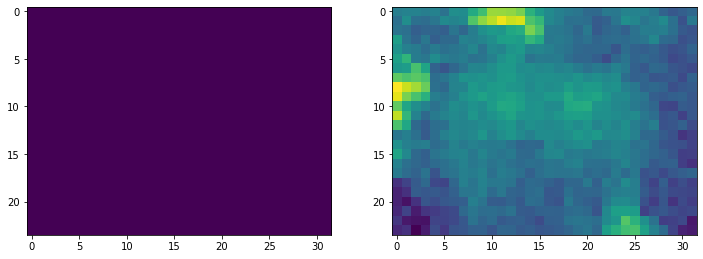

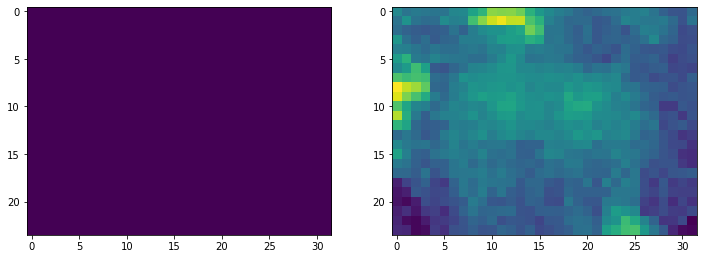

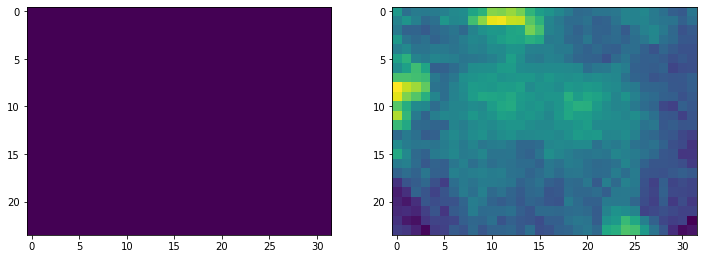

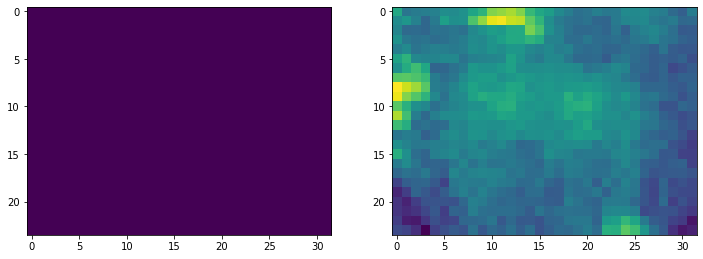

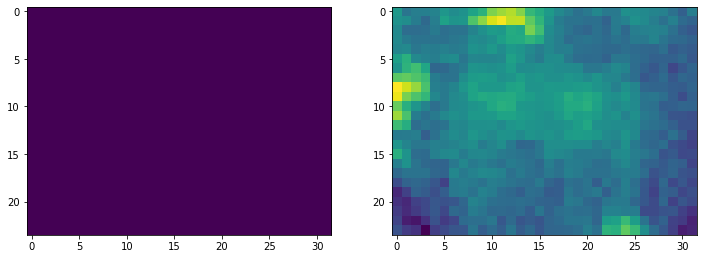

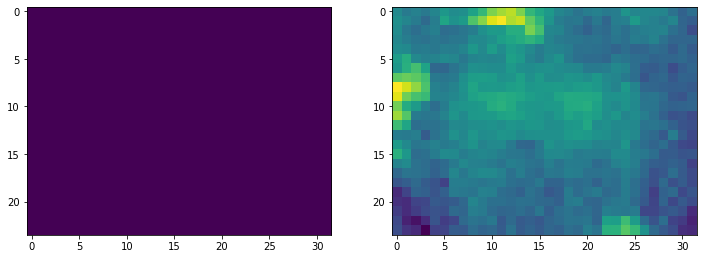

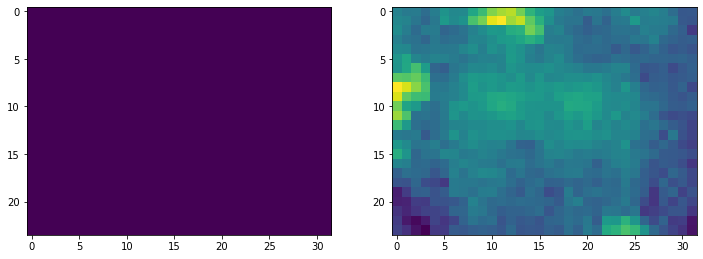

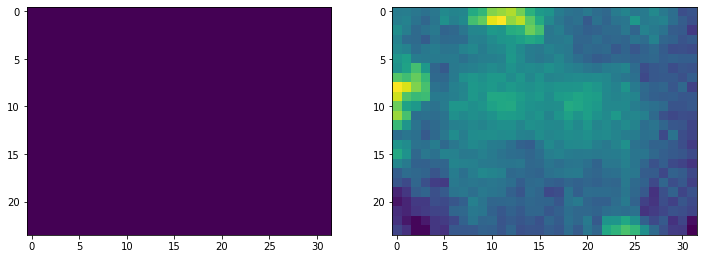

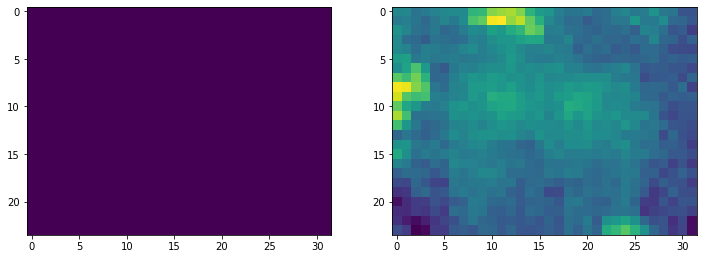

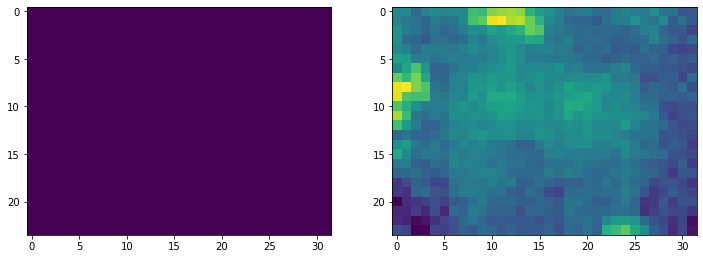

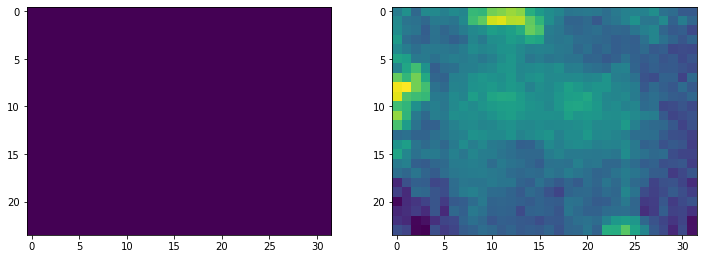

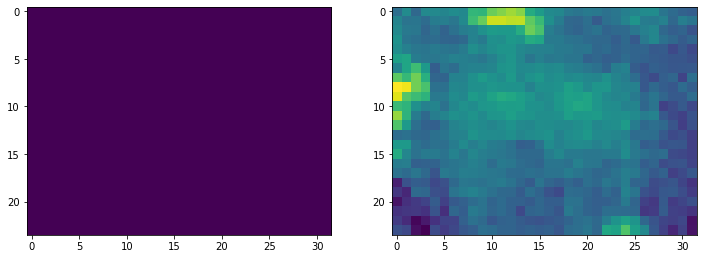

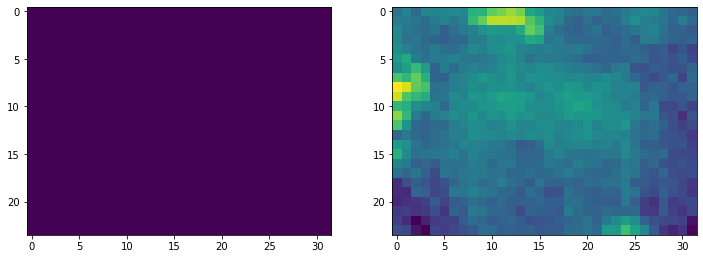

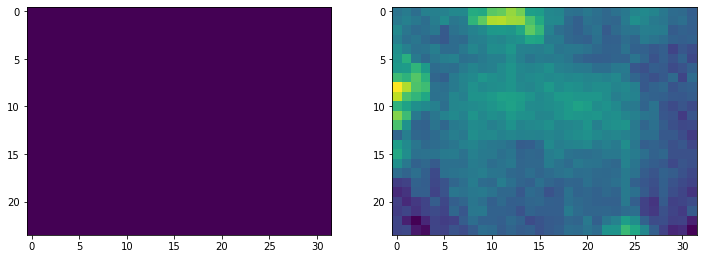

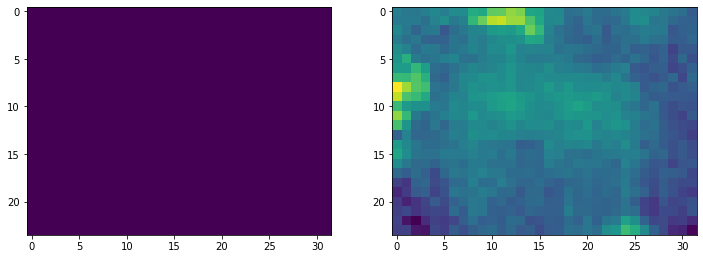

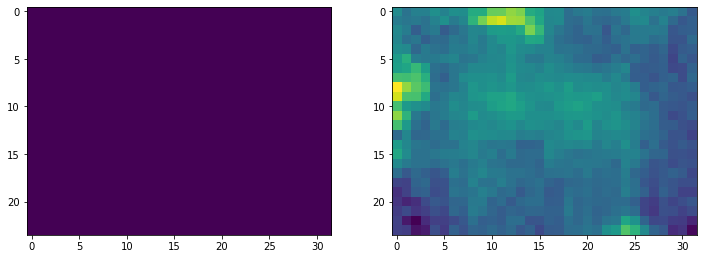

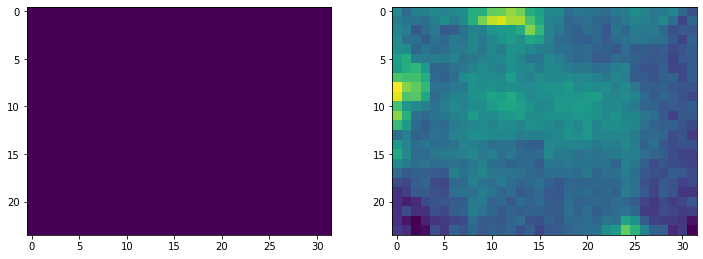

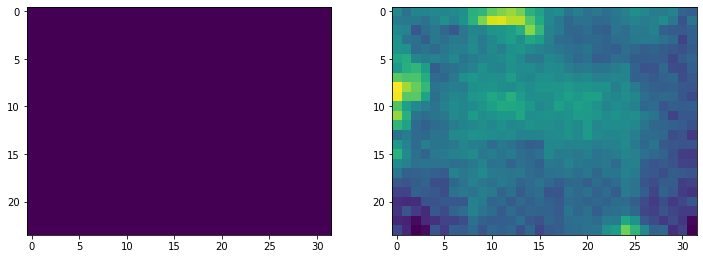

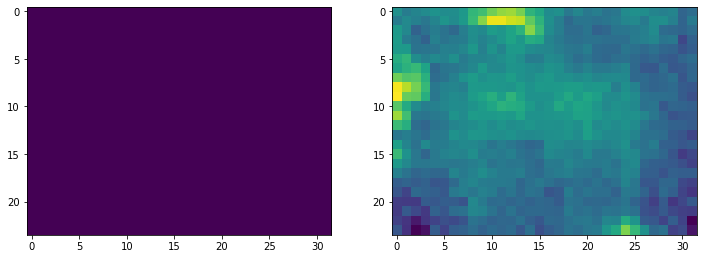

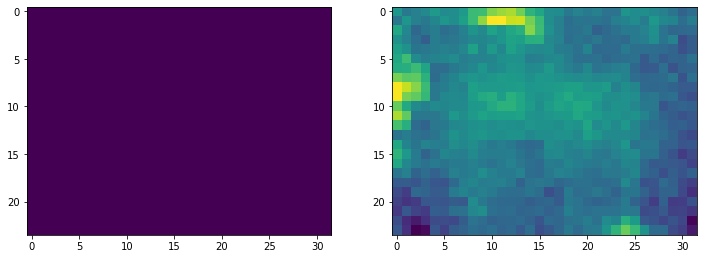

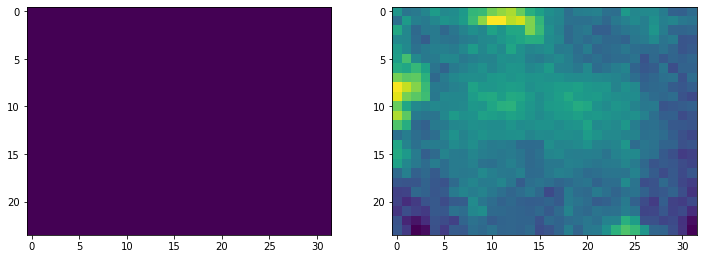

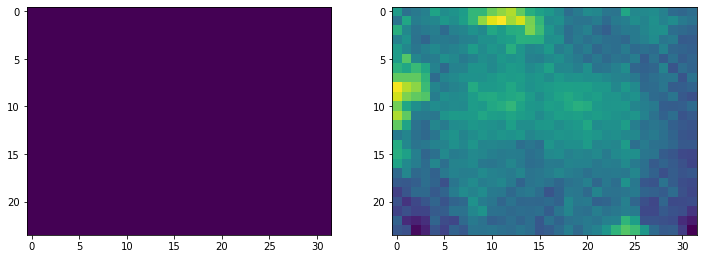

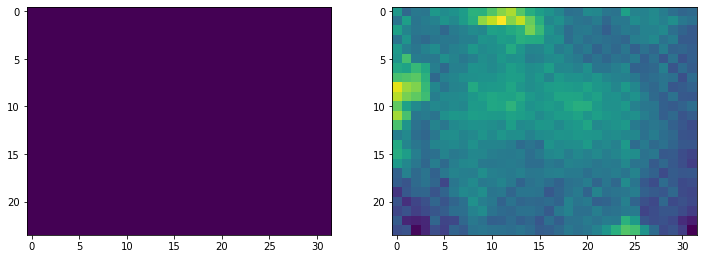

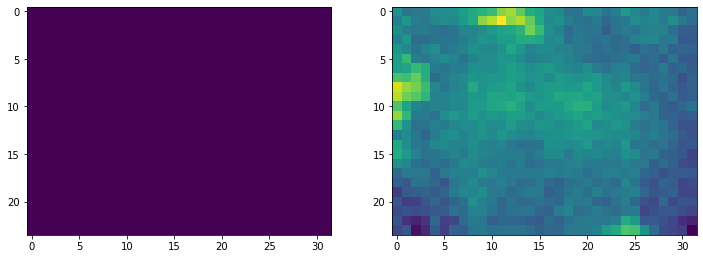

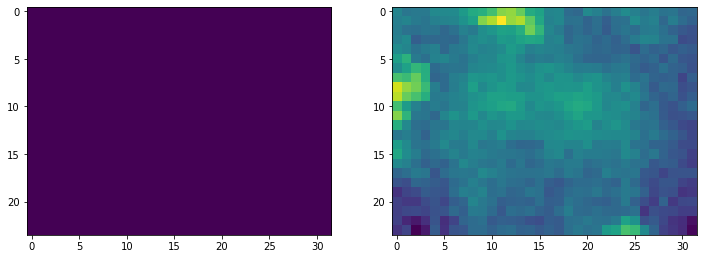

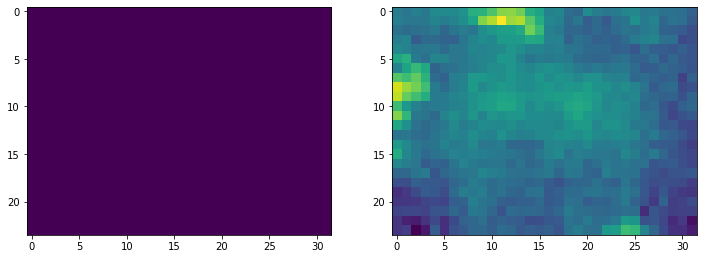

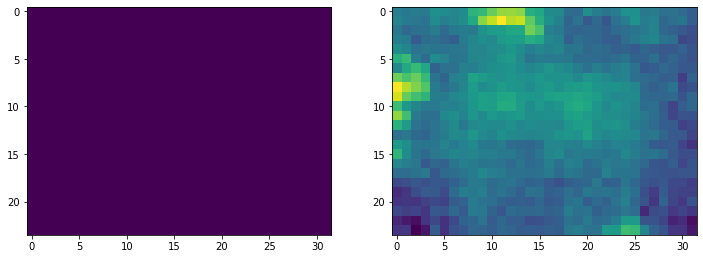

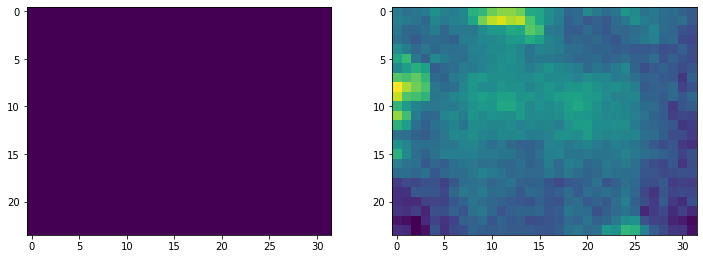

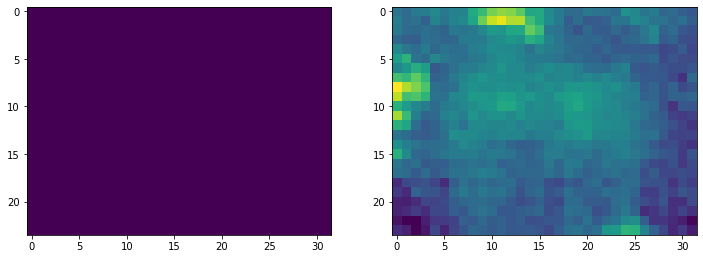

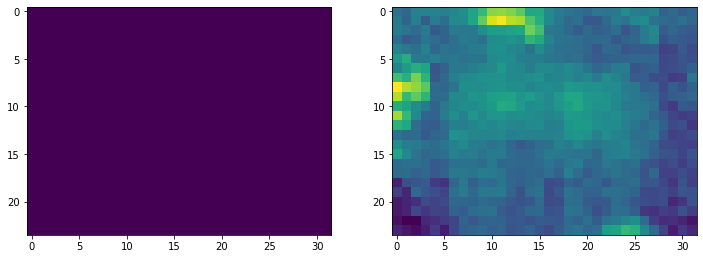

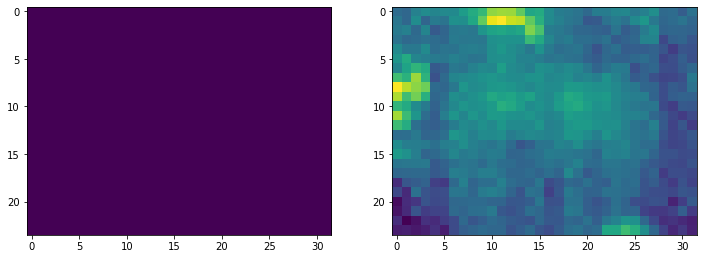

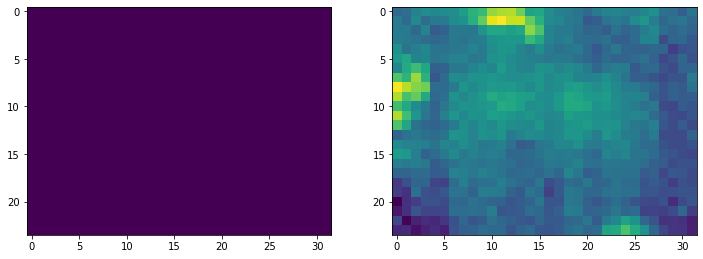

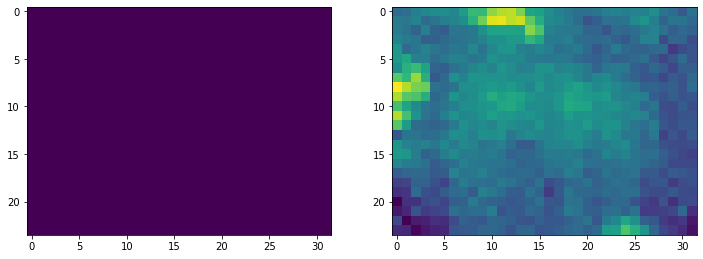

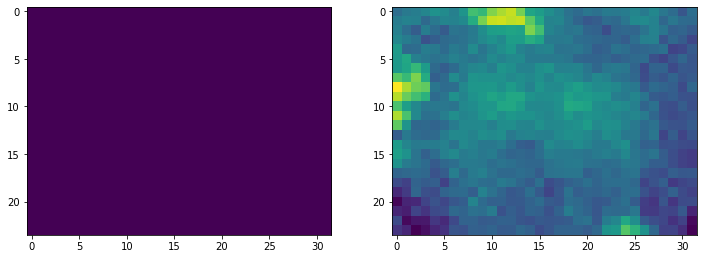

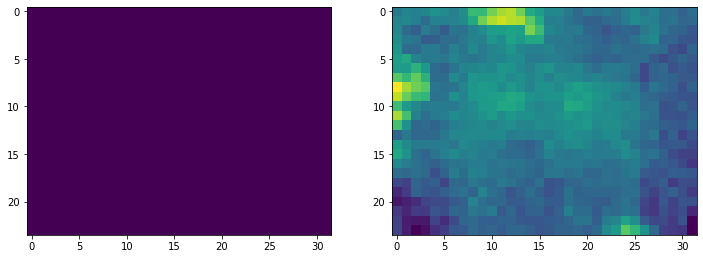

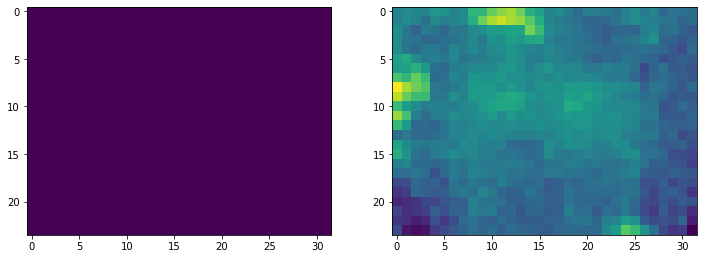

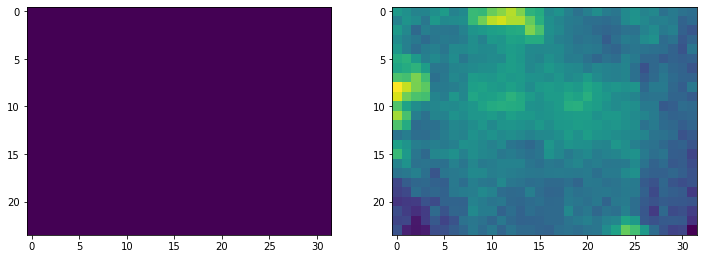

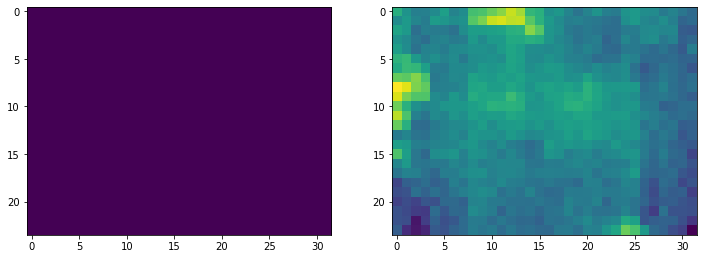

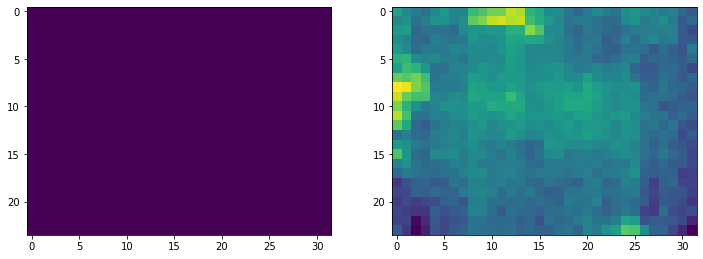

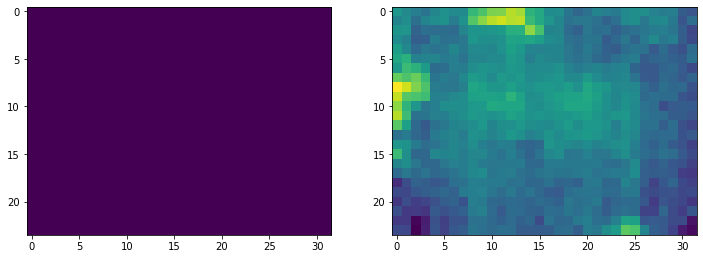

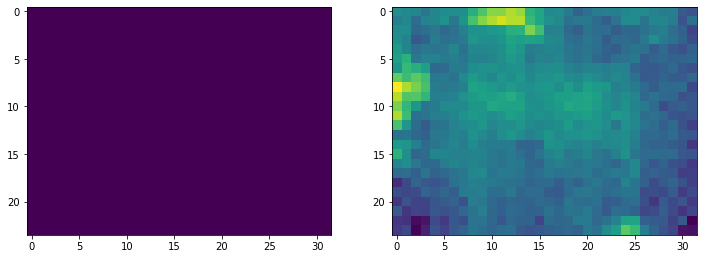

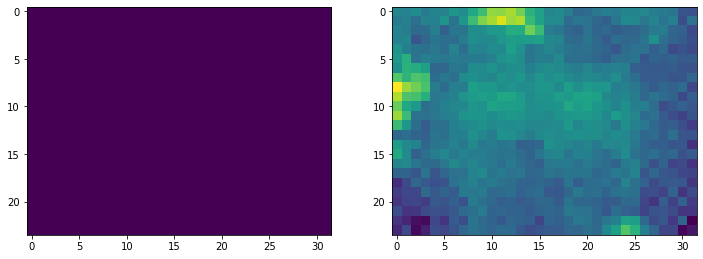

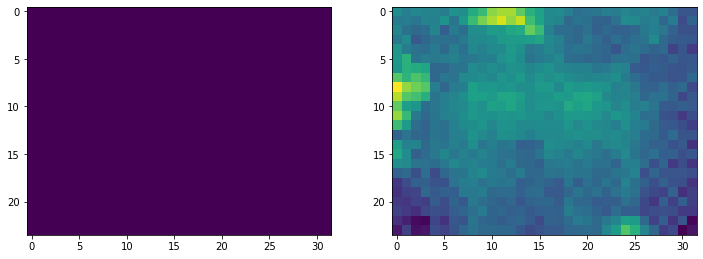

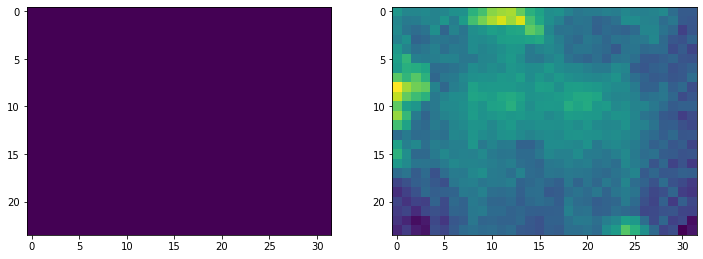

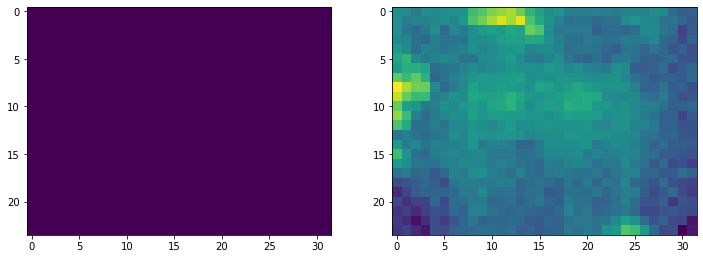

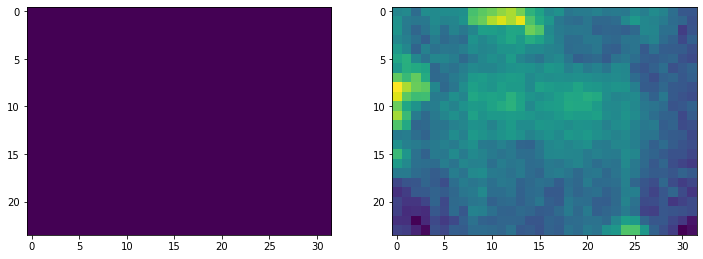

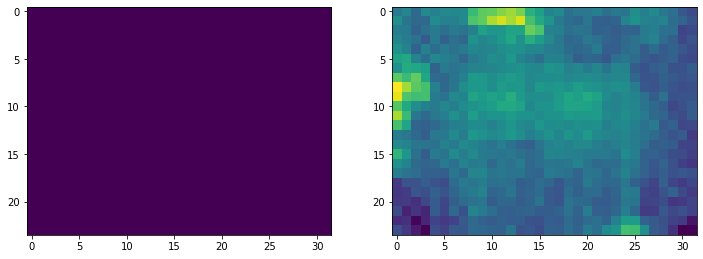

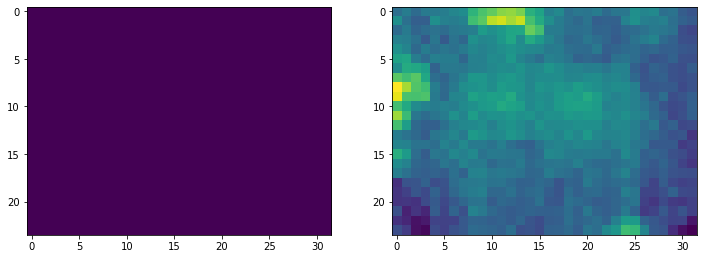

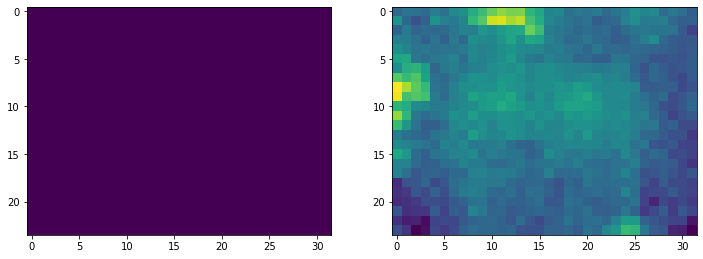

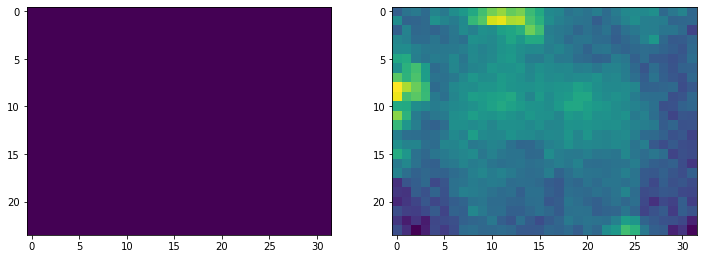

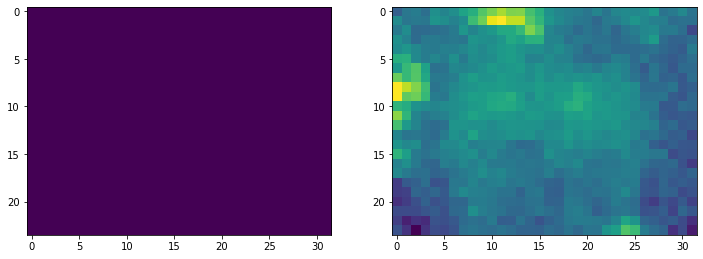

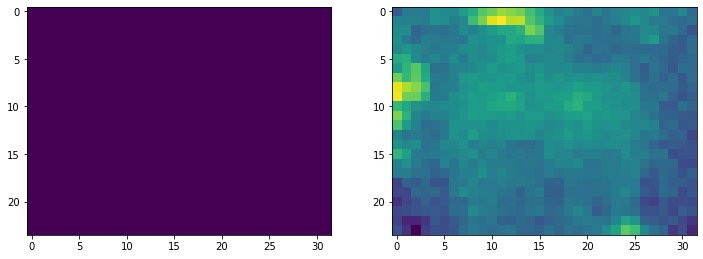

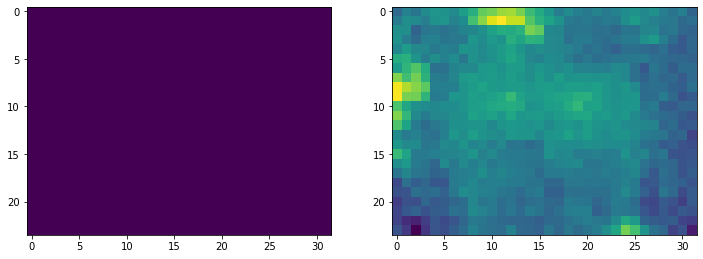

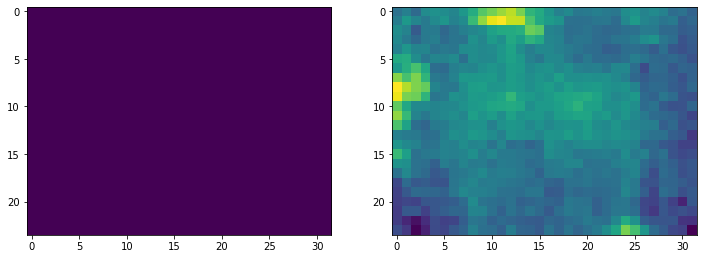

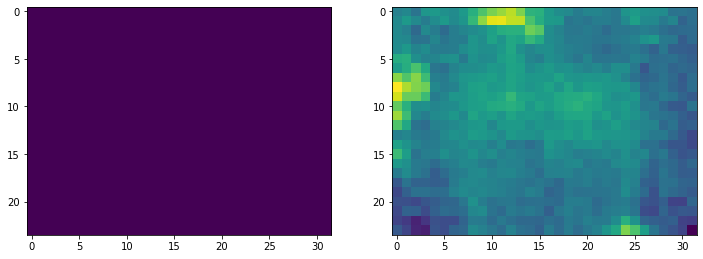

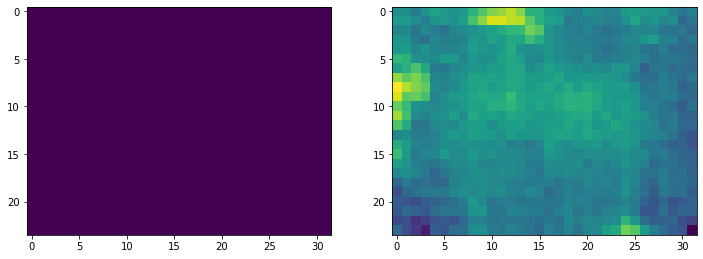

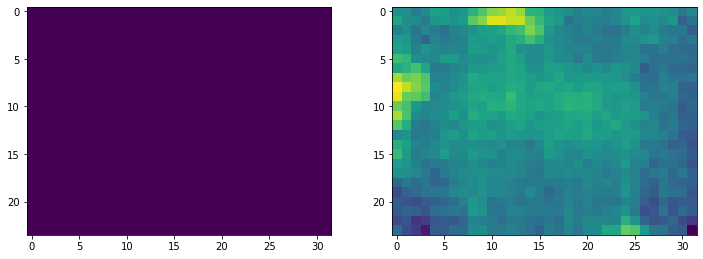

In [ ]:
pixel_model=[]
gif3_vibe=[]
pixel_model=np.array(pixel_model,np.float)
for i in range(gif3_mov_avg.shape[0]):
  temp = gif3_mov_avg[i]
  temp1,pixel_model = vibe_backsub(temp,pixel_model,r_param = 50,update_rate=16)
  gif3_vibe.append(temp1)
  plt.rcParams['figure.figsize'] = (12,12)
  plt.subplot(1,2,1)
  plt.imshow(temp)
  plt.subplot(1,2,2)
  plt.imshow(temp1)
  plt.show()
gif3_vibe = np.array(gif3_vibe)  

### 3.目标定位

In [ ]:
def active_sensor(data):
  size=data.shape[0]
  start=0
  end=0
  temp=0
  for i in range(size):
    if np.all(data[i,:,:]==0):
      if start!=0:
        temp+=1
        if temp==5:
          end=i-5
          return start,end
          break
      continue
    elif start==0:
      start=i
    else:
      temp = 0 
  return start,end     

In [ ]:
start,end = active_sensor(gif3_vibe)
print('Sensor Starting at Frame No.%d, End at Frame No.%d'%(start,end))

Sensor Starting at Frame No.87, End at Frame No.187


In [ ]:
def target_loc(datas):
  x = list()
  y = list()
  init_prop = 4
  max_prop = 8
  size=datas.shape[0]

  for i in range(size):
    data=datas[i,:,:]
    label_mat, num = measure.label(data,connectivity=1,return_num=True)
    props = measure.regionprops(label_mat)

    if num==0:
      x.append(x[-1])
      y.append(y[-1])  
    else:
      size=np.array(x).shape[0]
      for prop in props:
        centr = prop.centroid
        y1 = centr[0]
        x1 = centr[1]
        #print(centr)
        if prop.area > init_prop:
          if size==0:
            x.append(x1)
            y.append(y1)
          elif np.square(y1-y[-1])+np.square(x1-x[-1])>36:
            x.append(x[-1])
            y.append(y[-1])
          else:  
            if np.array(x).shape[0]==size:  
              x.append(x1)
              y.append(y1) 
      if np.array(x).shape[0]==size:
        x.append(x[-1])
        y.append(y[-1])    

  return x,y,max_prop  

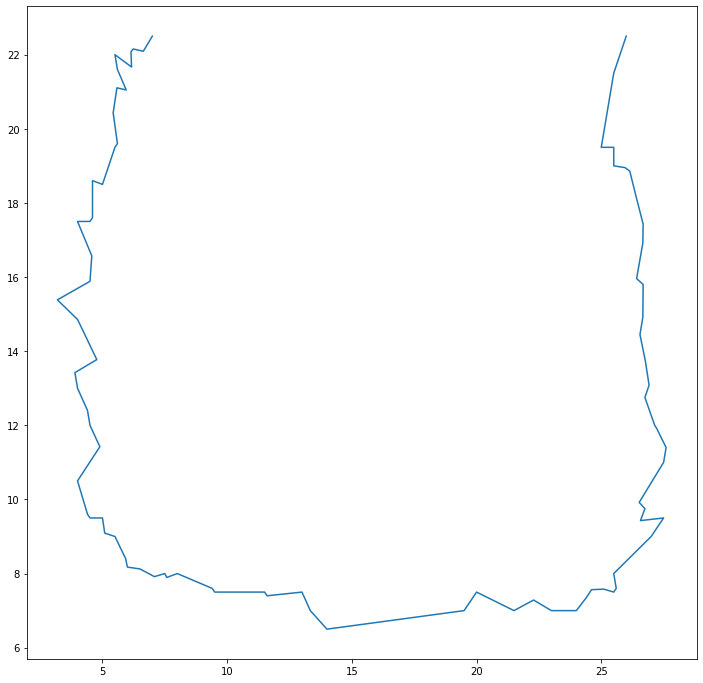

In [ ]:
x,y,max_prop = target_loc(gif3_vibe[start:end,:,:])
x=np.array(x,dtype=np.float)
y=np.array(y,dtype=np.float)
plt.plot(x,y)

### 4.全局坐标变换


In [ ]:
i=2
print('No.%d TPA Sensors at %.1f,%.1f,%d deg'%(i+1,loc_x[i],loc_y[i],loc_angle[i]))

No.3 TPA Sensors at 210.0,410.5,90 deg


In [ ]:
def coordinate_trans(x,y,loc_x,loc_y,angle):
  size = x.shape[0]
  pi = 3.14159
  for i in range(size):
    delta_x = (x-16)/32*37.1
    delta_y = (y-12)/24*20
    delta_z = np.sqrt(np.square(delta_x)+np.square(delta_y))
    gamma = np.arctan(delta_x/delta_y)/pi*180
    bar_x = np.abs(delta_z*np.cos(angle+gamma-90))
    bar_y = np.sqrt(np.square(delta_z)-np.square(bar_x))
    if angle>0:
      out_x = loc_x+bar_x
      out_y = loc_y-bar_y
    else:
      out_x = loc_x-bar_x
      out_y = loc_y+bar_y
  return out_x,out_y        

In [ ]:
real_x,real_y = coordinate_trans(x,y,loc_x[i],loc_y[i],angle[i])

### 5.目标跟踪

In [ ]:
model1 = tf.keras.Sequential()
model1.add(layers.Bidirectional(layers.LSTM(units=8,
                return_sequences =False ,
                activation='relu'),input_shape=(10,1)))
model1.add(layers.Dense(16))
model1.add(layers.Dense(2))

model1.summary()
#model1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), loss="mse", metrics=["acc"])
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mse", metrics=["acc"])

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 16)                640       
_________________________________________________________________
dense_76 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_77 (Dense)             (None, 2)                 34        
Total params: 946
Trainable params: 946
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2 = tf.keras.Sequential()
model2.add(layers.Dense(32,input_shape=(10,),activation='relu'))
model2.add(layers.Dense(16))
model2.add(layers.Dense(2))

model2.summary()
#model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss="mean_squared_error")
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss="mse", metrics=["acc"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 914
Trainable params: 914
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Result for Y axis')

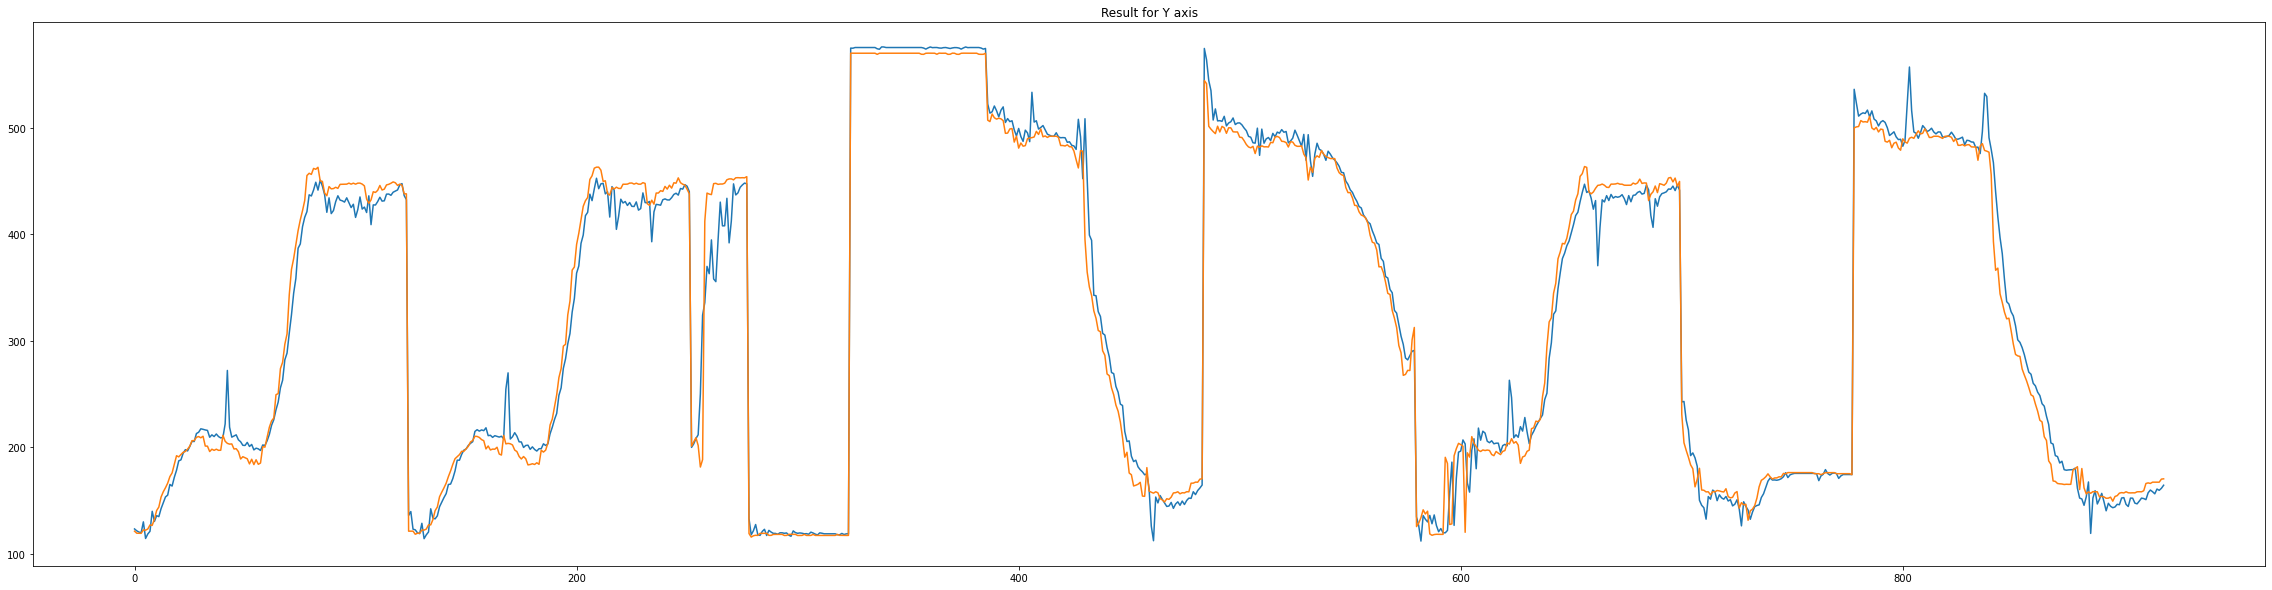

In [ ]:
plt.plot(y2[:,0])
plt.plot(ytest[:,0])
plt.title('Result for Y axis')

#### 5.1 训练数据集构建

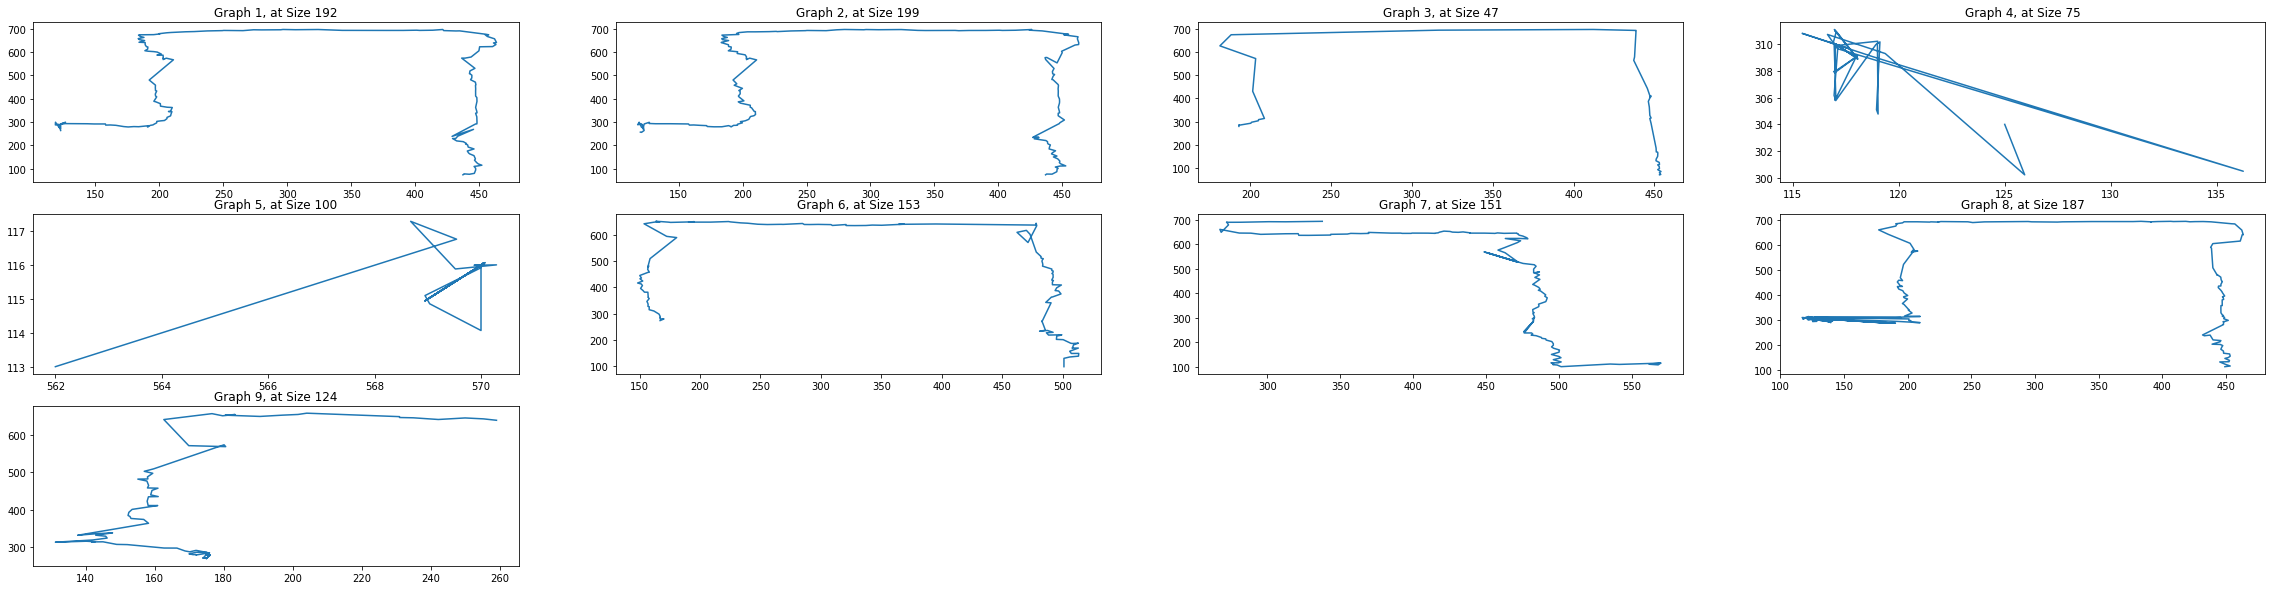

In [ ]:
j=1
for i in range(1,10):
 
  path='./train_data/'+str(i)+'.npy'
  temp = np.load(path)
  
  #print(temp.shape[0])
  plt.rcParams['figure.figsize'] = (40,10)
  plt.subplot(3,4,j)
  j=j+1
  plt.plot(temp[:,0],temp[:,1])
  plt.title('Graph %d, at Size %d'%(i,temp.shape[0]))

In [ ]:
train_X=[]
train_Y=[]
test_X=[]
test_Y=[]
for i in range(1,10):
  path='./train_data/'+str(i)+'.npy'
  temp = np.load(path)
  len = int(temp.shape[0]/3-2)
  for j in range(0,len):
    train_X.append(temp[3*j:3*j+5,:].reshape(-1))
    #train_X.append(temp[3*j:3*j+5,:])
    train_Y.append(temp[3*j+5,:])
    test_X.append(temp[3*j+1:3*j+6,:].reshape(-1))
    test_Y.append(temp[3*j+6,:])
    test_X.append(temp[3*j+2:3*j+7,:].reshape(-1))
    test_Y.append(temp[3*j+7,:])
path='./train_data/'+str(10)+'.npy'
temp = np.load(path)
len = int(temp.shape[0]-6)
for j in range(0,len):
  test_X.append(temp[j:j+5,:].reshape(-1))
  test_Y.append(temp[j+5,:]) 
xtrain=tf.stack(np.around(train_X,2))
xtrain1=np.reshape(xtrain,(xtrain.shape[0],10,1))
ytrain=tf.stack(train_Y)
xtest=tf.stack(np.around(test_X))
xtest1=np.reshape(xtest,(xtest.shape[0],10,1))
ytest=tf.stack(test_Y)
print(xtest.shape)
print(ytrain.shape)    

(919, 10)
(389, 2)


In [ ]:
model2.fit(xtrain1,ytrain,epochs=5)
#model2.save('my_model.h5')
#y1=model1.predict(xtest1)

#### 5.2 实际应用

①：实际运用前预训练

In [ ]:
model1 = tf.keras.Sequential()
model1=tf.keras.models.load_model('my_model1.h5')
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse", metrics=["acc"])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 16)                640       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
Total params: 946
Trainable params: 946
Non-trainable params: 0
_________________________________________________________________


②：实际使用时预测

### 6.仿真实验

In [ ]:
x_loc = [315.8,458.5,137.9]
y_loc = [652.0,184.6,238.9]
theta = [0,57,-80]

In [ ]:
def traj(t):
  if t<20:
    x=580-t*5
    y=70
  elif t<40:
    x=480
    y=70+(t-20)*8+0.4*(t-20)*(t-20)
  elif t<60:
    x=480
    y=390+(t-40)*8
  elif t<80:
    x=480
    y=550+(t-60)*8-0.2*(t-60)*(t-60)
  elif t<110:
    x=480-(t-80)*10
    y=630
  elif t<150:
    x=180
    y=630-(t-110)*7.5
  elif t<180:
    x=180+(t-150)*9
    y=330-(t-150)*9
  elif t<220:
    x=450+(t-180)*3.25  
    y=60    
  return x,y  
def judge_in(x_loc,y_loc,x,y,theta,show_param = False):
  flag=0
  temp_x = x-x_loc
  temp_y = y-y_loc
  tx = np.cos(theta)*temp_x-np.sin(theta)*temp_y
  ty = np.cos(theta)*temp_y+np.sin(theta)*temp_x
  x_image = tx/185.5*16+16
  y_image = ty/100*12+12
  x_image = np.round(x_image,1)
  y_image = np.round(y_image,1)
  #alpha=np.arctan2(x-x_loc,y_loc-y)
  #deg=alpha+theta/180*3.1415926
  #len=np.sqrt((x_loc-x)*(x_loc-x)+(y_loc-y)*(y_loc-y))
  #temp_x=len*np.cos(deg)
  #temp_y=len*np.sin(deg)
  if -185.5<=tx<=185.5:
    if -100<=ty<=100:
      flag = 1
  if show_param == True:
    print('x %.2f ,y %.2f,in?%d'%(tx,ty,flag))    
  return flag,x_image,y_image

In [ ]:
x=[]
y=[]
seen=[]
for i in range(0,220):
  temp_x,temp_y = traj(i)
  temp_flag = 0
  x.append(temp_x)
  y.append(temp_y)
  for i in range(3):
    flag,x_image,y_image = judge_in(x_loc[i],y_loc[i],temp_x,temp_y,theta[i])
    if flag:
      temp_flag = i+1

  seen.append(temp_flag) 

x = np.array(x)
y = np.array(y)
seen = np.array(seen) 

for i in range(150,170):
  if seen[i]==2:
    seen[i]=0
for i in range(170,200):
  if seen[i]==0:
    seen[i]=2    

#plt.plot(x,y) 
plt.plot(seen)  

(-0.1, 3.1)

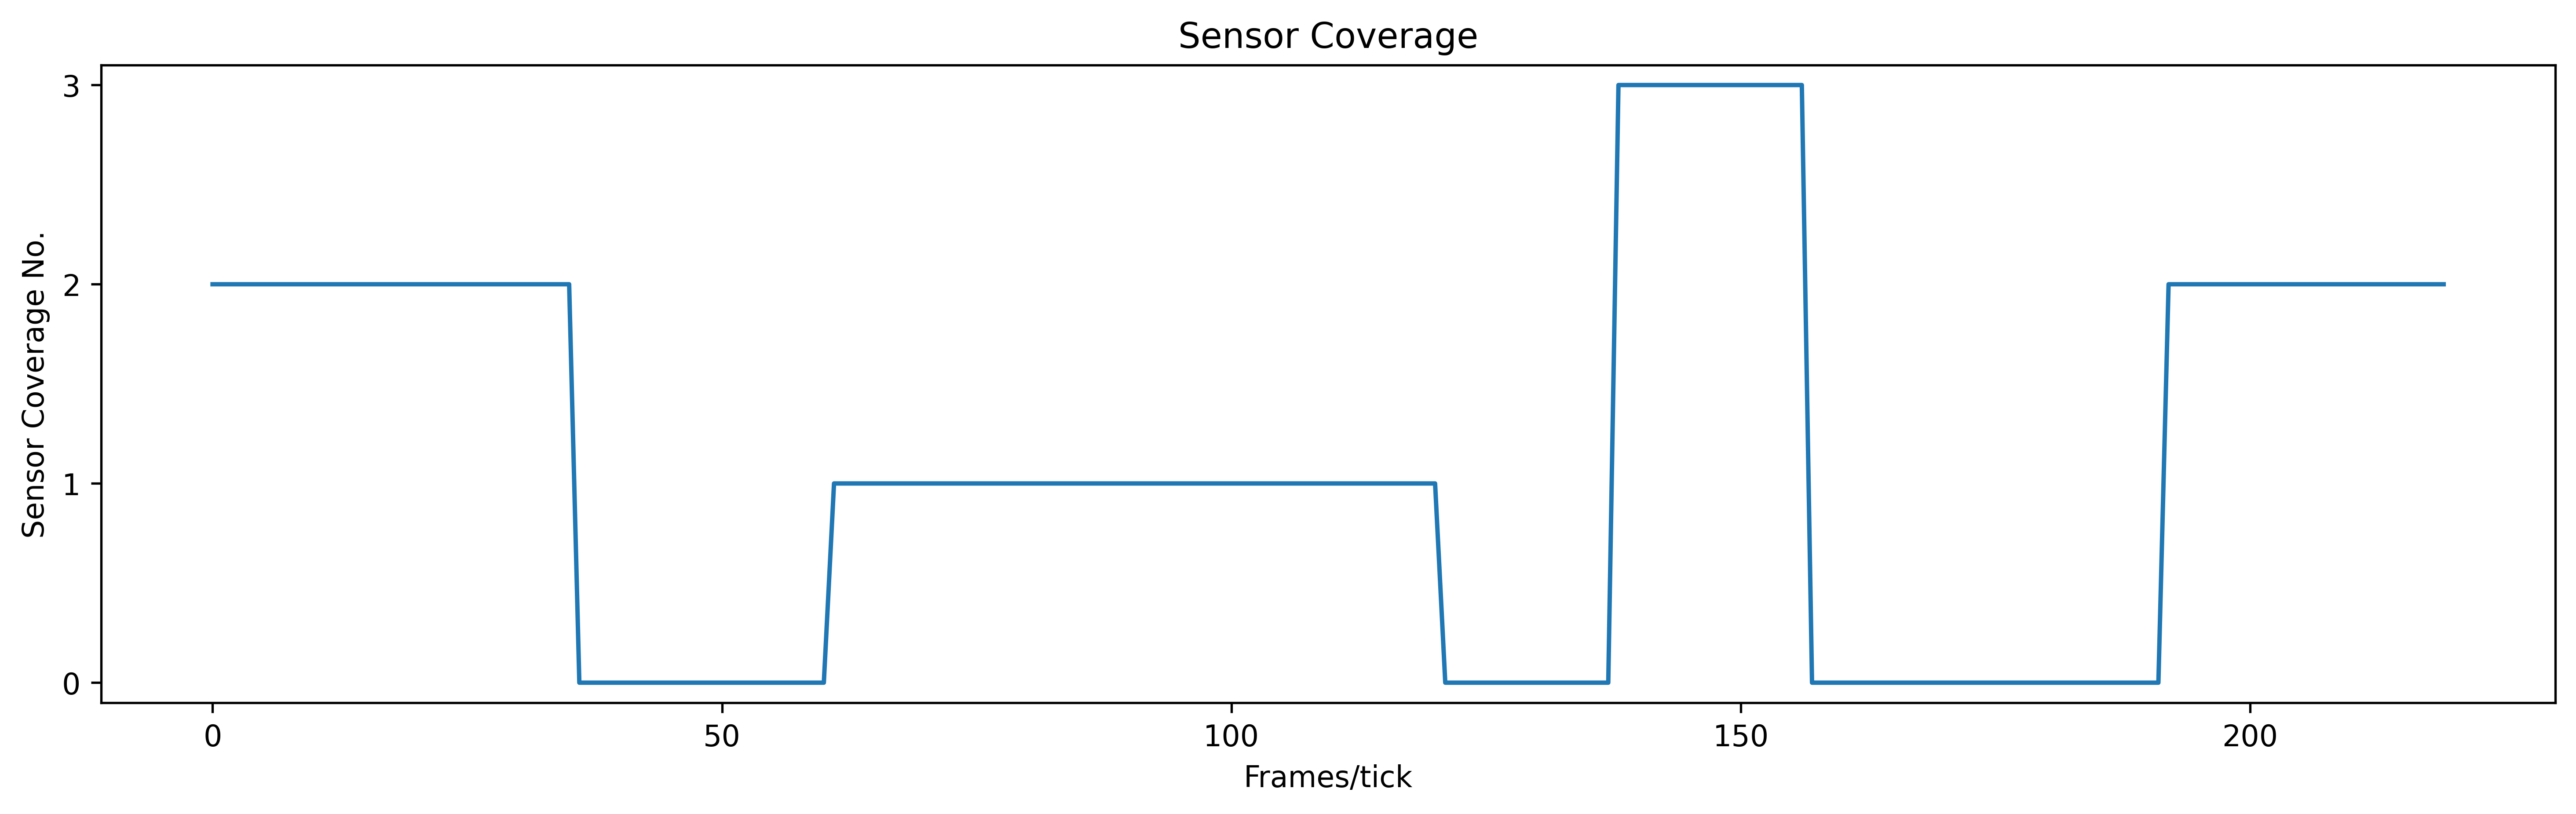

In [ ]:
plt.rcParams['figure.figsize'] = (15,4)
plt.rcParams['figure.dpi'] = 480
plt.plot(seen)
plt.title('Sensor Coverage')
plt.xlabel('Frames/tick')
plt.ylabel('Sensor Coverage No.')
plt.yticks([0,1,2,3])
plt.ylim(-0.1,3.1)



In [ ]:
x_image=np.zeros(220)
y_image=np.zeros(220)

for i in range(220):
  if seen[i]!=0:
    flag,x_image[i],y_image[i] = judge_in(x_loc[seen[i]-1],y_loc[seen[i]-1],x[i],y[i],theta[seen[i]-1])
    #print(flag)

In [ ]:
x_final = copy.deepcopy(x)
y_final = copy.deepcopy(y)

noise1=np.random.randn(220)
noise2 = np.random.randn(220)
for i in range(220):
  if seen[i]==0:
    noise1[i] = 0
    noise2[i] = 0
  elif x_image[i]<3 or x_image[i]>29 or y_image[i]<3 or y_image[i]>21:
    x_final[i] = x_final[i] + 5*noise1[i]
    y_final[i] = y_final[i] + 5*noise2[i]
  else:
    x_final[i] = x_final[i] + 3*noise1[i] 
    y_final[i] = y_final[i] + 3*noise2[i]  


In [ ]:
seen_flag = 0
x_fix=[]
y_fix=[]
for i in range(220):
  if seen[i]:
    seen_flag+=1
    if seen_flag>=5:
      seen_flag=0
      for j in range(5):
        x_fix.append([x_final[i+j-5],y_final[i+j-5]])
      x_fix = np.array(x_fix).reshape(1,10)
      x_fix1=np.reshape(x_fix,(x_fix.shape[0],10,1))
      #print(x_fix.shape)
      y_fix = np.array([x_final[i],y_final[i]]).reshape(1,2)
      #print(y_fix.shape)  
      #if i>39 or i<31:
      model1.fit(x_fix1,y_fix,epochs=1,verbose=1)
      x_fix=[]
      x_fix1=[]
      y_fix=[]
  else:
    seen_flag = 0
    for j in range(5):
      x_fix.append([x_final[i+j-4],y_final[i+j-4]])
    x_fix = np.array(x_fix).reshape(1,10)
    x_fix1=np.reshape(x_fix,(x_fix.shape[0],10,1))
    #print(x_fix)
    result = model1.predict(x_fix1)
    #print('Before %.2f,%.2f,after %.2f,%.2f'%(x_final[i],y_final[i],result[0,0],result[0,1]))
    x_final[i] = result[0,0]
    y_final[i] = result[0,1]
    x_fix = []  


1/1 [==============================] - 0s 11ms/step - loss: 305.2518 - acc: 1.0000


In [ ]:
count = 0
for i in range(220):
  if seen[i]==0:
    count+=1
print(count)    

77


In [ ]:
for i in range(70):
  if seen[i]==0:
    x_final[i] = x[i]+np.random.randn(1)*(6+(i-30)/4)

In [ ]:
x_err = x_final-x
y_err = y_final-y
err = np.zeros(220)
for i in range(220):
  err[i] = np.sqrt(x_err[i]*x_err[i]+y_err[i]*y_err[i])

Text(0, 0.5, 'Distance/cm')

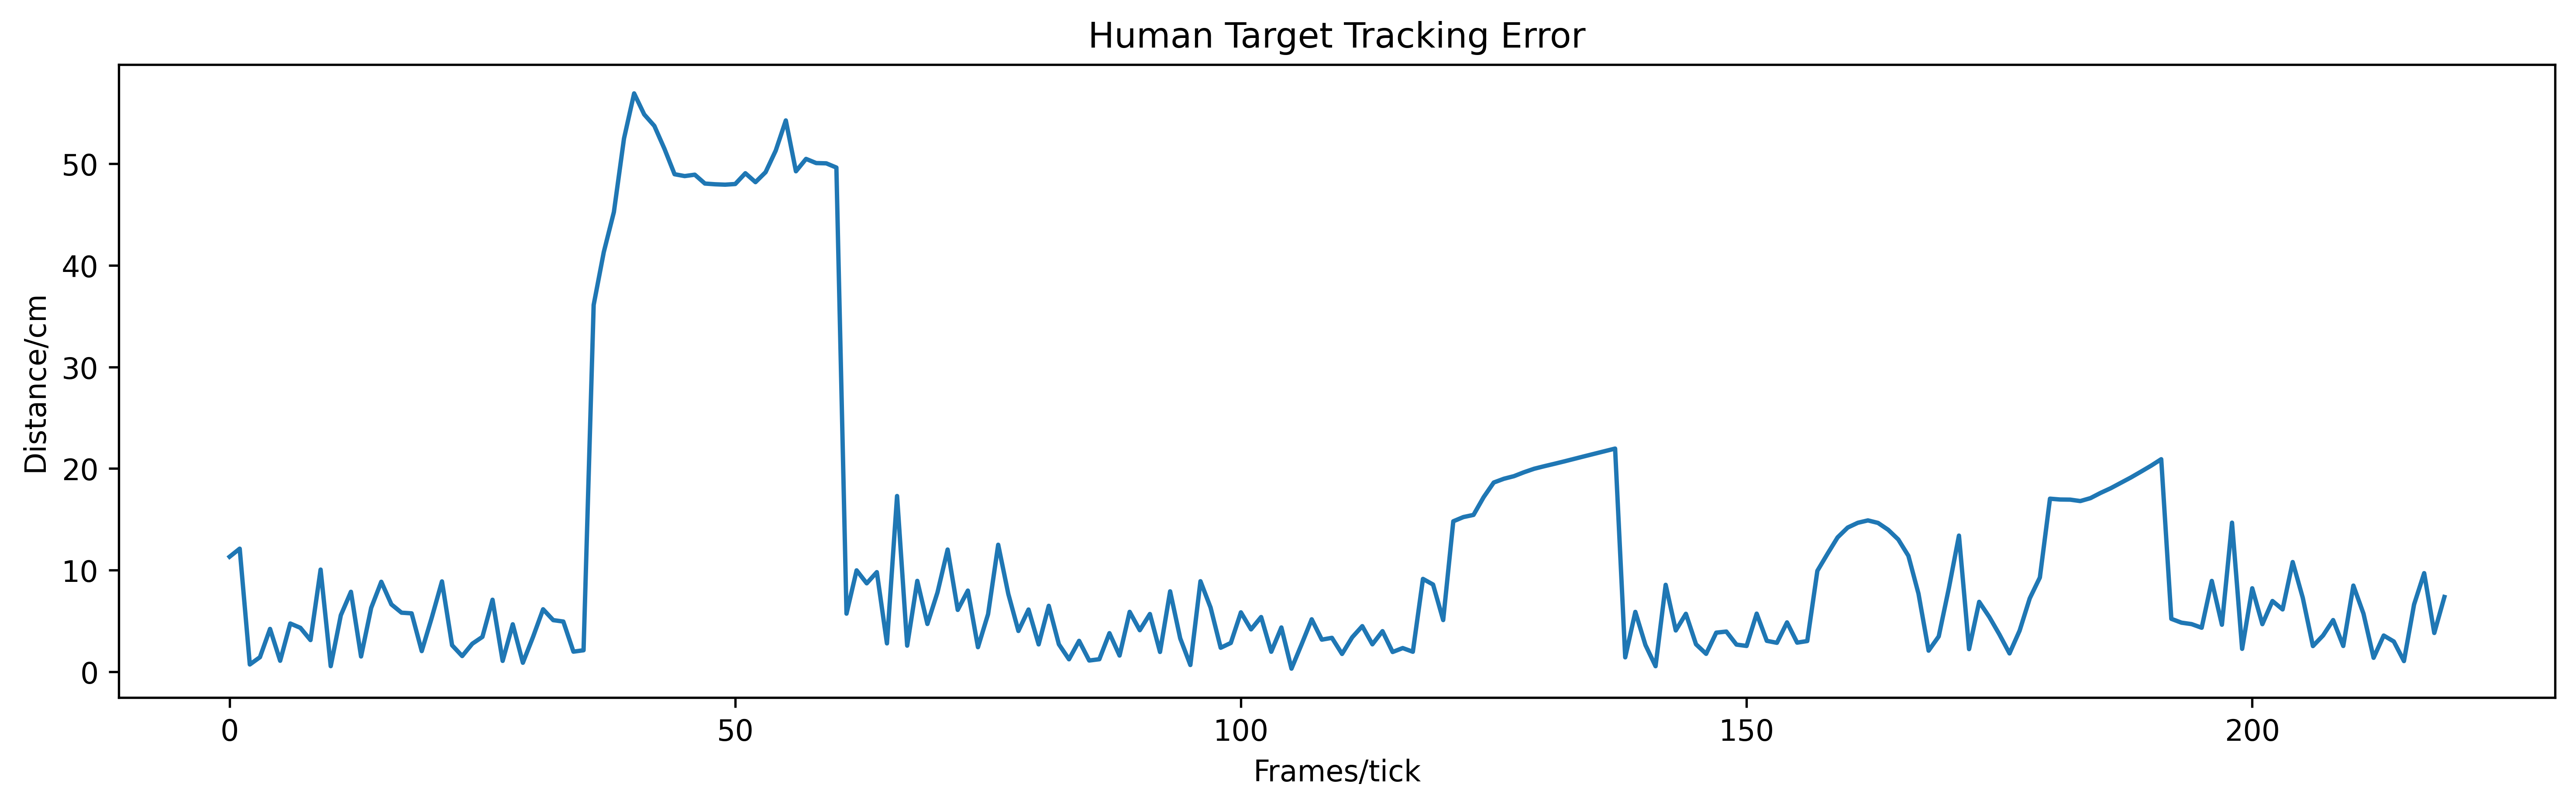

In [ ]:
plt.plot(err)
plt.title('Human Target Tracking Error')
plt.xlabel('Frames/tick')
plt.ylabel('Distance/cm')


In [ ]:
t=0
te=0
mte=0
tn=0
ten=0
mten=0
for i in range(220):
  if seen[i]:
    t+=1
    te += err[i]
    if err[i]>mte:
      mte = err[i]
  else:
    tn+=1
    ten += err[i]  
    if err[i]>mten:
      mten = err[i] 


print(te/t)
print(mte)
print(ten/tn)
print(mten)    

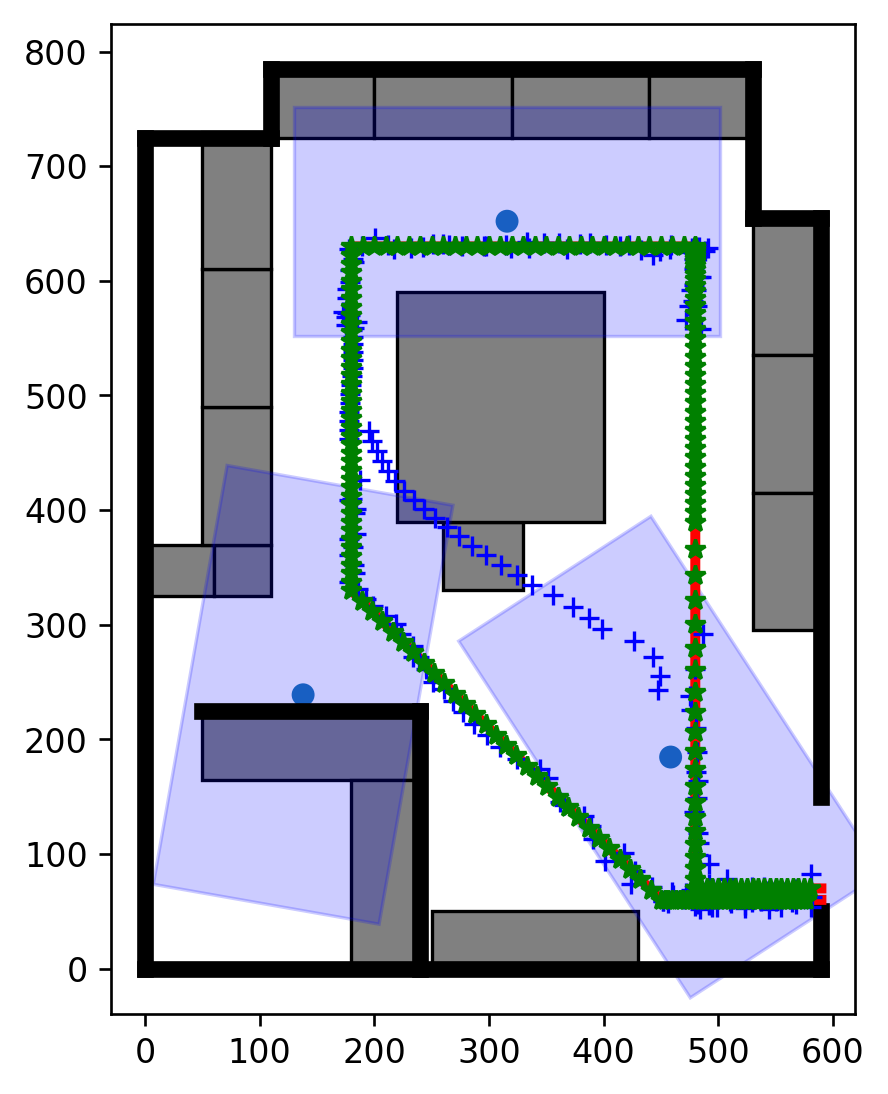

In [ ]:
from matplotlib import patches
from pylab import mpl
fig = plt.figure(figsize=(4,6),dpi=240)
axes = fig.add_subplot(111)
axes.plot([0, 0], [0, 725], color='k', linewidth=5)
axes.plot([0, 110], [725, 725], color='k', linewidth=5)
axes.plot([110, 110], [725, 785], color='k', linewidth=5)
axes.plot([110, 530], [785, 785], color='k', linewidth=5)
axes.plot([530, 530], [785, 655], color='k', linewidth=5)
axes.plot([530, 590], [655, 655], color='k', linewidth=5)
axes.plot([590, 590], [655, 150], color='k', linewidth=5)
axes.plot([590, 590], [50, 0], color='k', linewidth=5)
axes.plot([590, 0], [0, 0], color='k', linewidth=5)
axes.plot([240, 240], [0, 225], color='k', linewidth=5)
axes.plot([240, 50], [225, 225], color='k', linewidth=5)
axes.axis('scaled')
axes.add_patch(patches.Rectangle((0, 325), 60, 45, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((60, 325), 50, 45, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((50, 370), 60, 120, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((50, 490), 60, 120, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((50, 610), 60, 120, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((110, 725), 90, 60, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((200, 725), 120, 60, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((320, 725), 120, 60, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((440, 725), 90, 60, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((530, 535), 60, 120, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((530, 415), 60, 120, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((530, 295), 60, 120, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((260, 330), 70, 60, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((220, 390), 180, 200, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((50, 165), 190, 60, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((180, 0), 60, 165, edgecolor='k', facecolor='grey'))
axes.add_patch(patches.Rectangle((250, 0), 180, 50, edgecolor='k', facecolor='grey'))
plt.axis('scaled')

axes.plot([590,480,480,180,180,450,590],[70,70,630,630,330,60,60],color='r',linewidth=3)
for i in range(3):
  center = axes.transData
  trans = mpl.transforms.Affine2D().rotate_deg_around(x_loc[i], y_loc[i],-theta[i]) + center
  axes.add_patch(patches.Circle(xy=(x_loc[i], y_loc[i]),radius=10))
  axes.add_patch(patches.Rectangle((x_loc[i] - 371/2,y_loc[i]-100),371,200,edgecolor='b', facecolor='b',alpha=0.2, transform=trans)) 

axes.plot(x_final,y_final,'b+',label='True Value')
axes.plot(x,y,'g*',label='Ablation Value')

##### 消融实验 

In [ ]:
#a:104-117,b:84-92,c:152-158,d:31-39


In [ ]:
x_fix=[]
x_ab=x_final[31:39]
y_ab=y_final[31:39]
for i in range(32,39):
  for j in range(5):
    x_fix.append([x_final[i+j-4],y_final[i+j-4]])
  x_fix = np.array(x_fix).reshape(1,10)
  x_fix1=np.reshape(x_fix,(x_fix.shape[0],10,1))
  result = model1.predict(x_fix1)
  x_final[i]=result[0,0]
  y_final[i]=result[0,1]
  x_fix=[]
  print()  

##### 数据生成

In [ ]:
fat_guy = [     {'ROW': 0, 'COL': 1, 'T': 24.},
           {'ROW': 0, 'COL': 2, 'T': 24.},
           {'ROW': 0, 'COL': 3, 'T': 24.},
           {'ROW': 0, 'COL': 4, 'T': 24.},
           {'ROW': 1, 'COL': 1, 'T': 24.},
           {'ROW': 1, 'COL': 2, 'T': 25.},
           {'ROW': 1, 'COL': 3, 'T': 25.},
           {'ROW': 1, 'COL': 4, 'T': 24.},
           {'ROW': 2, 'COL': 0, 'T': 22.5},
           {'ROW': 2, 'COL': 1, 'T': 24.},
           {'ROW': 2, 'COL': 2, 'T': 24.5},
           {'ROW': 2, 'COL': 3, 'T': 24.5},
           {'ROW': 2, 'COL': 4, 'T': 24.},
           {'ROW': 2, 'COL': 5, 'T': 23.},
           {'ROW': 3, 'COL': 0, 'T': 22.5},
           {'ROW': 3, 'COL': 1, 'T': 23.5},
           {'ROW': 3, 'COL': 2, 'T': 24.},
           {'ROW': 3, 'COL': 3, 'T': 24.},
           {'ROW': 3, 'COL': 4, 'T': 24.},
           {'ROW': 3, 'COL': 5, 'T': 22.5},
           {'ROW': 4, 'COL': 0, 'T': 23.},
           {'ROW': 4, 'COL': 1, 'T': 24.},
           {'ROW': 4, 'COL': 2, 'T': 23.5},
           {'ROW': 4, 'COL': 3, 'T': 23.5},
           {'ROW': 4, 'COL': 4, 'T': 24.},
           {'ROW': 5, 'COL': 0, 'T': 23.},
           {'ROW': 5, 'COL': 1, 'T': 23.5},
           {'ROW': 5, 'COL': 2, 'T': 23.},
           {'ROW': 5, 'COL': 3, 'T': 23.3},
           {'ROW': 5, 'COL': 4, 'T': 23.9}]    

fat = np.zeros((6,6))
f_c_x=2.6
f_c_y=2.3
for i in range(0,30):
  temp = fat_guy[i]
  fat[temp.get('ROW'),temp.get('COL')] = temp.get('T')  


In [ ]:
def trans(x1,y1,raw=fat):
  a = np.zeros((24,32))
  cx = 2.6
  cy = 2.3
  move_x = x1-cx
  move_y = y1-cy
  base_x = int(np.floor(move_x))
  var_x = np.round(move_x-np.floor(move_x),1)
  base_y = int(np.floor(move_y))
  var_y = np.round(move_y-np.floor(move_y),1)
  for i in range(6):
    for j in range(6):
      if 32>=base_x+i>=0:
        if 24>=base_y+j>=0:
          if j<5 and i<5:
            a[base_y+j,base_x+i]=(var_x*fat[i,j]+(1-var_x)*fat[i+1,j]+var_y*fat[i,j]+(1-var_y)*fat[i,j+1])/2 
          else:
            a[base_y+j,base_x+i]=fat[i,j]
  for i in range(0,24):
    for j in range(0,32):
      if a[i,j]<18:
        a[i,j]=18
  noise = np.random.randn(24,32)      
  a = a+noise
  return a 